In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import VAR
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

#### settings

In [57]:
data_path = r'C:\Users\yeswa\OneDrive\Desktop\time_series\data\Lowa_liquor sales\lowa_liquor_sales.csv'
# Define chunk size
chunk_size = 10000  # Adjust as needed
pd.set_option('display.max_rows', None)
# Assuming df is your DataFrame
pd.set_option('display.max_columns', None)

#### EDA

In [58]:
# # Initialize an empty list to store chunks
# chunks = []

# # Read the CSV file in chunks
# for chunk in pd.read_csv(data_path, chunksize=chunk_size):
#     chunks.append(chunk)

# # Concatenate all chunks into a single DataFrame
# df = pd.concat(chunks, ignore_index=True)

# # Display all columns
# # print(df.head(2))

In [59]:
# # Initialize an empty list to store chunks
# chunks = []

# # Read the CSV file in chunks
# for chunk in pd.read_csv(data_path, chunksize=chunk_size):
#     chunks.append(chunk)

# # Concatenate all chunks into a single DataFrame
# df = pd.concat(chunks, ignore_index=True)

# # Display all columns
# print(df.columns)

In [60]:
selected_cols = ['Date', 'Store Number', 'Store Name', 'Category', 'Category Name', 'Item Number', 'Bottles Sold', 'Sale (Dollars)']

df_liquor_sales = pd.read_csv(data_path, low_memory=False, usecols=selected_cols)

# Remove '$' symbol from 'Sale (Dollars)' column and convert it to numeric
df_liquor_sales['Sale (Dollars)'] = df_liquor_sales['Sale (Dollars)'].replace('\$', '', regex=True).astype(float)

df_liquor_sales.head()

Date  Store Number                        Store Name  Category  \
0  11/20/2015          2191                    Keokuk Spirits       NaN   
1  11/21/2015          2205            Ding's Honk And Holler       NaN   
2  11/16/2015          3549              Quicker Liquor Store       NaN   
3  11/04/2015          2513  Hy-Vee Food Store #2 / Iowa City       NaN   
4  11/17/2015          3942                  Twin Town Liquor       NaN   

  Category Name  Item Number  Bottles Sold  Sale (Dollars)  
0           NaN          297             6          162.84  
1           NaN          297            12          325.68  
2           NaN          249             2           19.20  
3           NaN          237             3          160.02  
4           NaN          249             2           19.20

Fetch all unique values from each column

In [61]:
# Assuming df is your DataFrame
unique_counts = df_liquor_sales.nunique()
data_types = df_liquor_sales.dtypes

# Convert the result to a DataFrame
unique_counts_df = pd.DataFrame({'Unique Values Count': unique_counts, 'Data Type': data_types})

# Sort the DataFrame based on unique values count
sorted_counts_df = unique_counts_df.sort_values(by='Unique Values Count', ascending=False)

sorted_counts_df

Unique Values Count Data Type
Sale (Dollars)                23154   float64
Item Number                    7395     int64
Store Name                     1952    object
Store Number                   1884     int64
Date                           1379    object
Bottles Sold                    450     int64
Category Name                   130    object
Category                        107   float64

Check missing values from each column

In [62]:
# Count the number of missing values per column
missing_values_per_column = df_liquor_sales.isnull().sum()

# Display the result
missing_values_per_column

Date                  0
Store Number          0
Store Name            0
Category           8020
Category Name     16086
Item Number           0
Bottles Sold          0
Sale (Dollars)       10
dtype: int64

In [63]:
df_liquor_sales.shape

(12591077, 8)

##### Top 25 Categories by Percentage of Sales

In [64]:
# Group by 'Category' and sum 'Sale (Dollars)'
category_sales = df_liquor_sales.groupby('Category Name')['Sale (Dollars)'].sum().reset_index()

# Calculate the total sales
total_sales = category_sales['Sale (Dollars)'].sum()

# Calculate the percentage of sales for each category
category_sales['Percentage of Sales'] = (category_sales['Sale (Dollars)'] / total_sales) * 100

# Display the result
sorted_sales_by_category_name = category_sales.sort_values(by='Percentage of Sales', ascending=False).head(25)

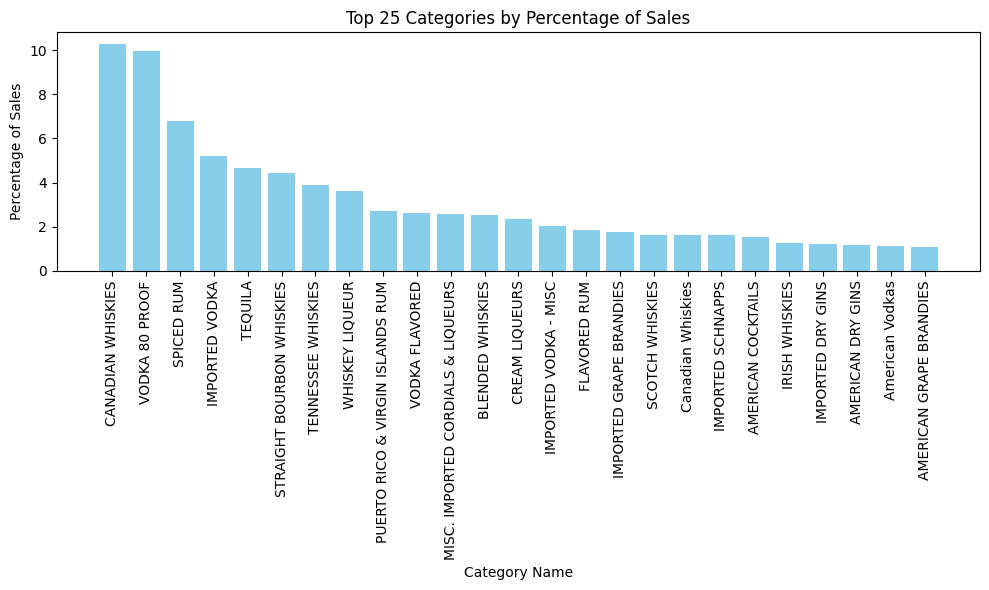

In [65]:
# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(sorted_sales_by_category_name['Category Name'], sorted_sales_by_category_name['Percentage of Sales'], color='skyblue')
plt.xlabel('Category Name')
plt.ylabel('Percentage of Sales')
plt.title('Top 25 Categories by Percentage of Sales')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


##### Top 10 Stores by Percentage of Sales

In [66]:
# Group by 'Store Name' and sum 'Sale (Dollars)'
store_sales = df_liquor_sales.groupby('Store Name')['Sale (Dollars)'].sum().reset_index()

# Calculate the total sales
total_sales = store_sales['Sale (Dollars)'].sum()

# Calculate the percentage of sales for each store
store_sales['Percentage of Sales'] = (store_sales['Sale (Dollars)'] / total_sales) * 100

# Display the result
sorted_sales_by_store_name = store_sales.sort_values(by='Percentage of Sales', ascending=False).head(10)
sorted_sales_by_store_name

Store Name  Sale (Dollars)  Percentage of Sales
831          Hy-Vee #3 / BDI / Des Moines     47301836.86             3.222163
466                        Central City 2     34490212.48             2.349446
959   Hy-Vee Wine and Spirits / Iowa City     19504472.29             1.328629
1534       Sam's Club 8162 / Cedar Rapids     19136490.76             1.303562
1528    Sam's Club 6344 / Windsor Heights     19102039.84             1.301216
1291                        Lot-A-Spirits     15154944.31             1.032343
507                 Costco Wholesale #788     14801486.31             1.008265
467             Central City Liquor, Inc.     12951946.42             0.882276
1535          Sam's Club 8238 / Davenport     12190623.83             0.830416
67                      Benz Distributing     12057838.26             0.821370

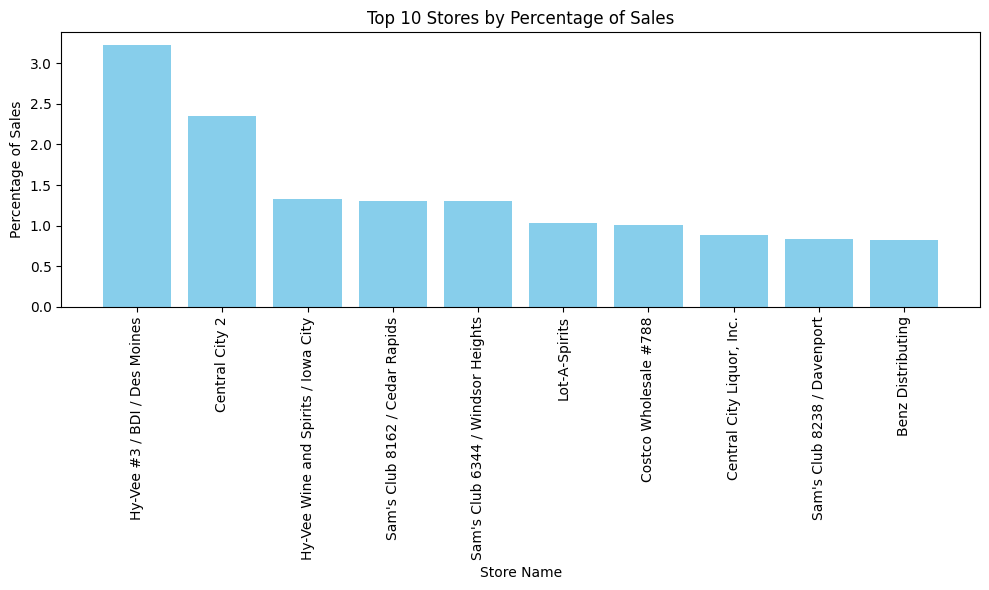

In [67]:
# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(sorted_sales_by_store_name['Store Name'], sorted_sales_by_store_name['Percentage of Sales'], color='skyblue')
plt.xlabel('Store Name')
plt.ylabel('Percentage of Sales')
plt.title('Top 10 Stores by Percentage of Sales')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [68]:
# Group by 'Date' and sum 'Bottles Sold'
date_sales = df_liquor_sales.groupby('Date')['Bottles Sold'].sum()

# Display the result
date_sales.tail()

Date
12/30/2016     9789
12/31/2012    90455
12/31/2013     6600
12/31/2014     5686
12/31/2015     1806
Name: Bottles Sold, dtype: int64

In [69]:
# Convert 'Date' column to pandas datetime
df_liquor_sales['Date'] = pd.to_datetime(df_liquor_sales['Date'])

# Group by 'Date' and aggregate 'Bottles Sold' and count of rows
date_sales = df_liquor_sales.groupby('Date').agg({'Bottles Sold': 'sum'}).rename(columns={'Bottles Sold': 'Total Bottles Sold'})

# Store the result as a DataFrame
date_sales_df = pd.DataFrame(date_sales)

# Display the result
date_sales_df.head()

Total Bottles Sold
Date                          
2012-01-03               78323
2012-01-04               69482
2012-01-05               77090
2012-01-09               77165
2012-01-10               71777

##### Get missing dates for each year and month

In [70]:
# Generate a complete date range for the DataFrame
date_range = pd.date_range(start=df_liquor_sales['Date'].min(), end=df_liquor_sales['Date'].max())

# Calculate missing dates
missing_dates = date_range.difference(df_liquor_sales['Date'])

# Extract year and month from missing dates
missing_dates_year = missing_dates.year
missing_dates_month = missing_dates.month

# Create a DataFrame with missing dates, year, and month
missing_dates_df = pd.DataFrame({'Year': missing_dates_year, 'Month': missing_dates_month})

# Pivot the DataFrame
missing_dates_pivot = missing_dates_df.pivot_table(index='Month', columns='Year', aggfunc='size', fill_value=0)

# Display the result
print("Missing Days per Year and Month:")
print(missing_dates_pivot)


Missing Days per Year and Month:
Year   2012  2013  2014  2015  2016  2017
Month                                    
1        11    12    12    14    15    10
2        12    10    12    11    10     8
3        12    14    13    12     9     8
4        12    11    11    12    12    10
5        11    10    13    13    10     7
6        11    10    12     8     9     8
7        11    11    12    12    11    10
8        11    11    14    13     8     8
9        12    12    13    10     8     9
10        8     9    10    12    10     9
11       11    10    13    12     9     0
12       12     8     8     9     9     0


#### seasonal_decompose
Seasonal decomposition is a technique used in time series analysis to decompose a time series into its underlying components: trend, seasonal, and residual. The seasonal decomposition process aims to separate the systematic patterns present in the data from the random fluctuations or noise. The trend component represents the long-term direction or overall behavior of the time series, while the seasonal component captures the recurring patterns or fluctuations that occur at fixed intervals, such as daily, weekly, or yearly cycles. The residual component represents the random variation or error left after removing the trend and seasonal components. Seasonal decomposition is valuable for understanding the underlying structure of time series data, identifying trends, detecting seasonality, and facilitating forecasting and modeling tasks. Techniques such as seasonal decomposition help analysts gain deeper insights into the dynamics of time series data and make more informed decisions in various fields, including economics, finance, and environmental studies.

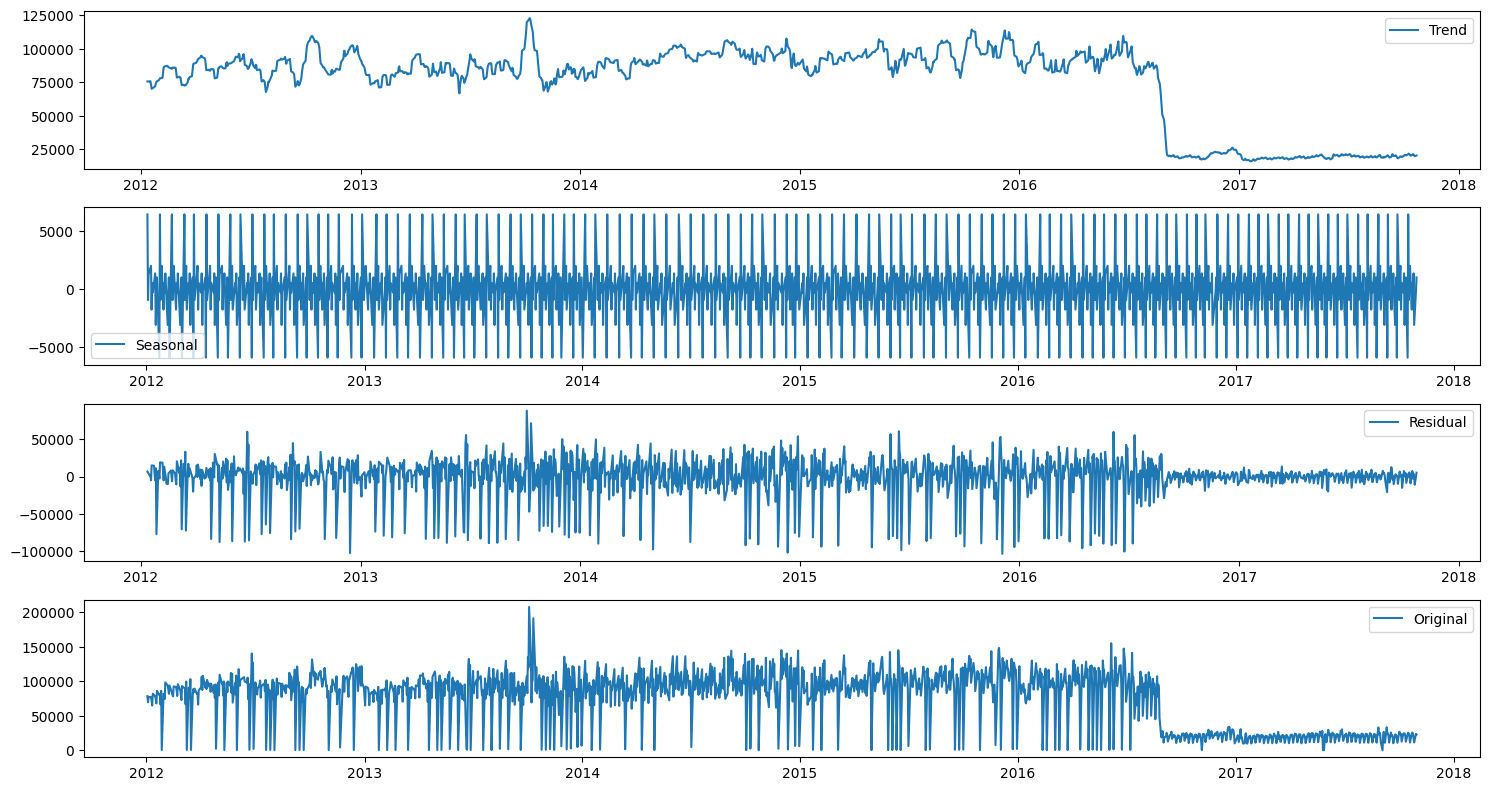

In [71]:
# Convert the 'Date' index to datetime if it's not already in datetime format
date_sales_df.index = pd.to_datetime(date_sales_df.index)

# Apply seasonal decomposition
decomposition = seasonal_decompose(date_sales_df['Total Bottles Sold'], model='additive', period=12)  # Assuming seasonality of 12 months

# Plot the decomposition
plt.figure(figsize=(15, 8))

plt.subplot(4, 1, 1)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(date_sales_df['Total Bottles Sold'], label='Original')
plt.legend()

plt.tight_layout()
plt.show()


#### Augmented Dickey-Fuller (ADF)
The Augmented Dickey-Fuller (ADF) test is a widely used statistical test in time series analysis to determine whether a given time series is stationary or non-stationary. Stationarity is a crucial assumption in many time series models, as it implies that the statistical properties of the series, such as mean and variance, do not change over time. The ADF test assesses the presence of a unit root in the data, where a unit root suggests non-stationarity. The test computes a test statistic along with a p-value, comparing them to critical values to determine significance. If the p-value is below a chosen threshold (often 0.05), the null hypothesis of the presence of a unit root is rejected, indicating stationarity. Otherwise, if the p-value is higher, the null hypothesis cannot be rejected, suggesting non-stationarity. The ADF test helps analysts understand the underlying behavior of time series data, aiding in the selection of appropriate modeling techniques and forecasting methods.

In [72]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(date_sales_df['Total Bottles Sold'])

# Extract test statistics and p-value
adf_statistic = adf_result[0]
p_value = adf_result[1]

# Print results
print("Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_statistic}")
print(f"P-value: {p_value}")

# Check for stationarity
if p_value < 0.05:
    print("The time series is likely stationary (reject null hypothesis)")
else:
    print("The time series is likely non-stationary (fail to reject null hypothesis)")

Augmented Dickey-Fuller Test Results:
ADF Statistic: -0.985224583023811
P-value: 0.7586150767030428
The time series is likely non-stationary (fail to reject null hypothesis)


#### Add values for missing dates using interpolate

In [73]:
# Convert 'Date' to datetime if it's not already in datetime format
date_sales_df.index = pd.to_datetime(date_sales_df.index)

# Resample the DataFrame to fill missing dates and interpolate total bottles sold values
date_sales_df_resampled = date_sales_df.resample('D').interpolate(method='linear')

# Display the resampled DataFrame
date_sales_df_resampled.sort_values(by='Total Bottles Sold', ascending=False).head()


Total Bottles Sold
Date                          
2013-10-04       207867.000000
2013-10-11       191400.000000
2013-10-05       183998.333333
2013-10-12       168602.333333
2013-10-06       160129.666667

With sales ranging from 1 to 207,867 units, the time series data reflects considerable variability in sales volume over time. This variability suggests the presence of diverse factors influencing consumer behavior, including seasonal trends, promotional activities, market dynamics, and external events. 

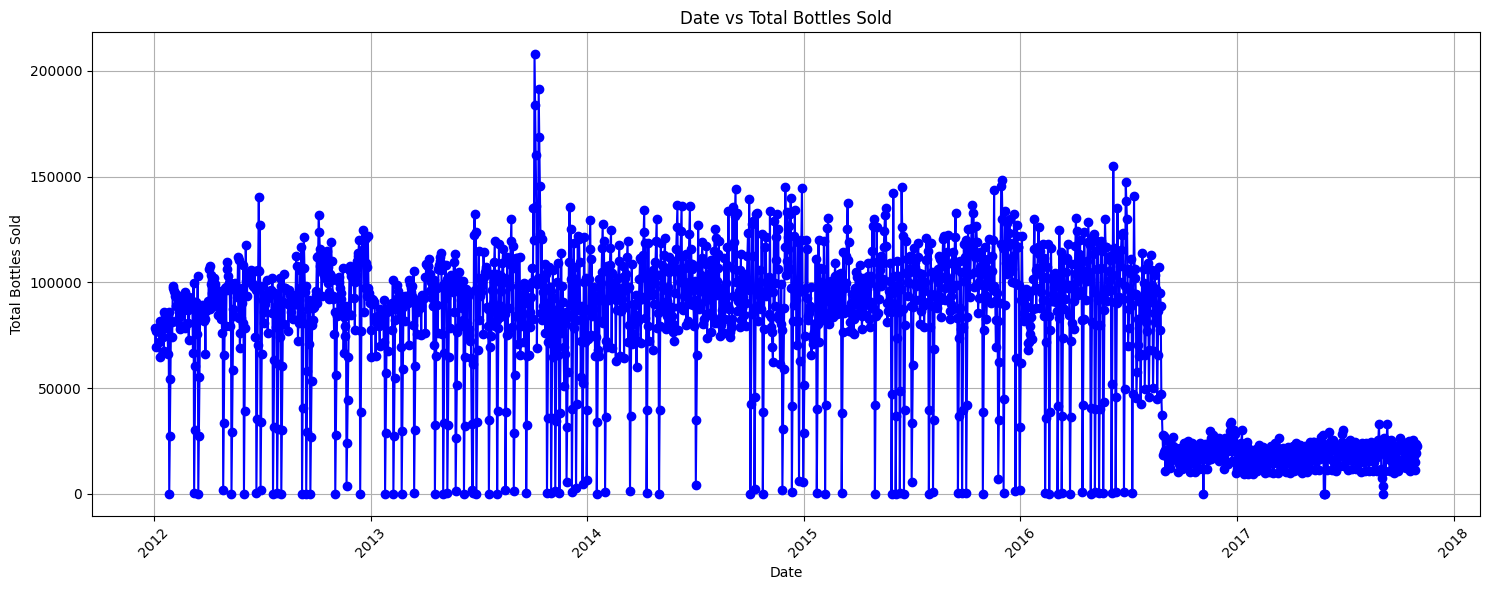

In [74]:
# Assuming 'date_sales_df_resampled' is your DataFrame with Date as the index
plt.figure(figsize=(15, 6))
plt.plot(date_sales_df_resampled.index, date_sales_df_resampled['Total Bottles Sold'], marker='o', color='blue', linestyle='-')
plt.title('Date vs Total Bottles Sold')
plt.xlabel('Date')
plt.ylabel('Total Bottles Sold')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


#### IQR outlier detection method

The Interquartile Range (IQR) outlier detection method is a statistical technique used to identify outliers in a dataset based on the distribution of the data. Here's a short summary:

The IQR is a measure of statistical dispersion, representing the range between the first quartile (Q1) and the third quartile (Q3) of a dataset. It is calculated as Q3 - Q1.

To detect outliers using the IQR method, the following steps are typically followed:

1. Calculate the IQR: Compute the IQR by subtracting the first quartile (Q1) from the third quartile (Q3).

2. Define the outlier boundaries: Multiply the IQR by a constant factor (usually 1.5) and add it to Q3 to get the upper bound and subtract it from Q1 to get the lower bound.

3. Identify outliers: Any data point that falls below the lower bound or above the upper bound is considered an outlier.

4. Optionally, adjust the constant factor: Depending on the dataset and the desired sensitivity to outliers, the constant factor can be adjusted.

The IQR method is robust to skewed distributions and is less sensitive to extreme values compared to other outlier detection methods like z-score or mean/standard deviation based methods.

In summary, the IQR outlier detection method provides a simple and effective way to identify outliers in a dataset by leveraging the quartiles and the spread of the data.

In [75]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = date_sales_df_resampled['Total Bottles Sold'].quantile(0.25)
Q3 = date_sales_df_resampled['Total Bottles Sold'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
cleaned_df = date_sales_df_resampled[date_sales_df_resampled['Total Bottles Sold'] <= upper_bound]

# Display cleaned dataset
cleaned_df = cleaned_df.reset_index()
cleaned_df.sort_values(by='Total Bottles Sold', ascending=False).head()

Date  Total Bottles Sold
646  2013-10-11       191400.000000
640  2013-10-05       183998.333333
647  2013-10-12       168602.333333
641  2013-10-06       160129.666667
1615 2016-06-06       155103.000000

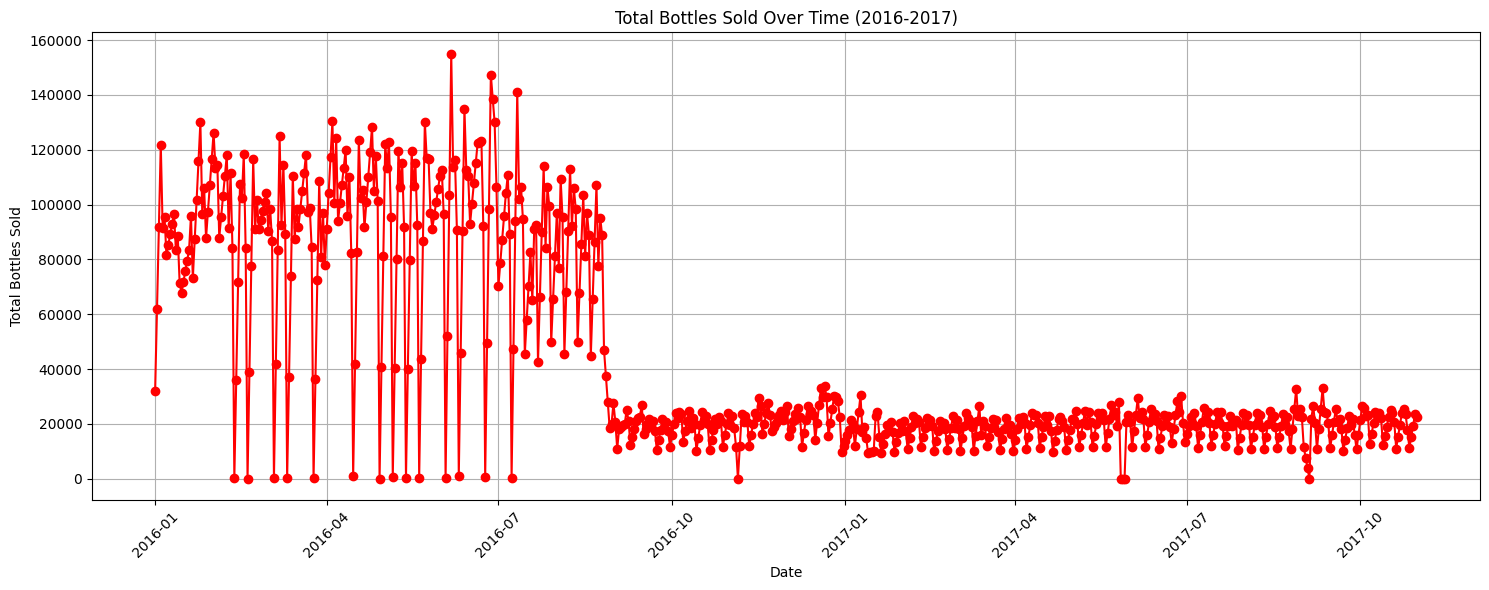

In [76]:
cleaned_df['Date'] = pd.to_datetime(cleaned_df['Date'])

# Filter data for the years 2016 and 2017 using .loc
filtered_df = cleaned_df.loc[(cleaned_df['Date'].dt.year == 2016) | (cleaned_df['Date'].dt.year == 2017)]

# Plotting the line plot
plt.figure(figsize=(15, 6))
plt.plot(filtered_df['Date'], filtered_df['Total Bottles Sold'], marker='o', linestyle='-', color='red')
plt.title('Total Bottles Sold Over Time (2016-2017)')
plt.xlabel('Date')
plt.ylabel('Total Bottles Sold')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

There are sudden drop in sales from August 25 2016 

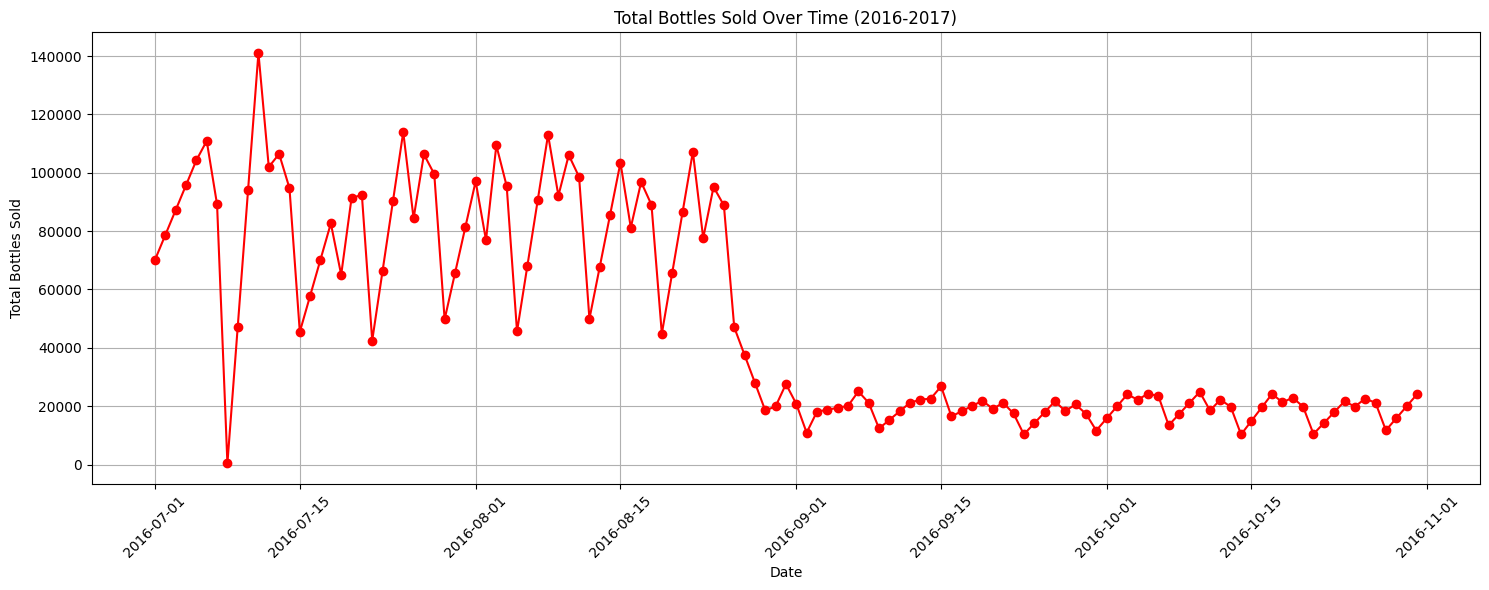

In [77]:
# Modify the filter to include data between July 2016 and October 2016
filtered_df_07_10_month = cleaned_df.loc[(cleaned_df['Date'] >= '2016-07-01') & (cleaned_df['Date'] <= '2016-10-31')]

# Plotting the line plot
plt.figure(figsize=(15, 6))
plt.plot(filtered_df_07_10_month['Date'], filtered_df_07_10_month['Total Bottles Sold'], marker='o', linestyle='-', color='red')
plt.title('Total Bottles Sold Over Time (2016-2017)')
plt.xlabel('Date')
plt.ylabel('Total Bottles Sold')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Filter data from August 28, 2016, and onwards

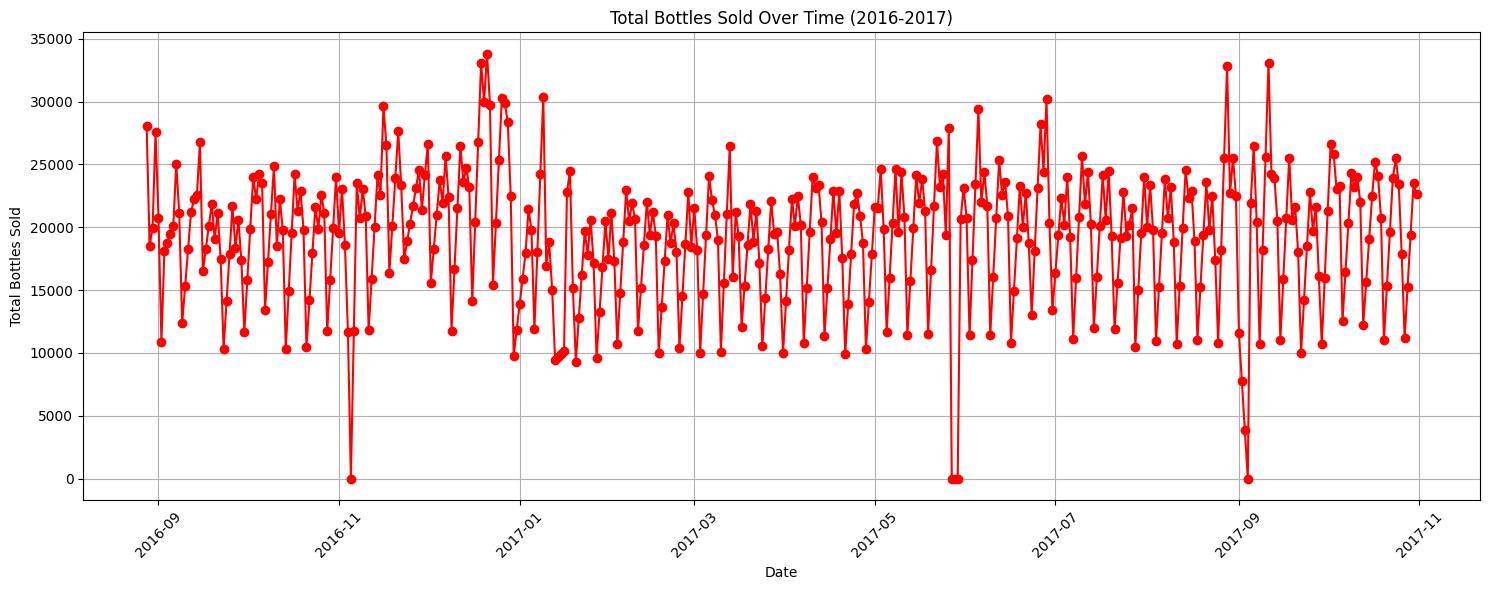

In [78]:
# Modify the filter to include data from August 28, 2016, and onwards
filtered_df_aug_2016 = cleaned_df.loc[cleaned_df['Date'] >= '2016-08-28']

# Plotting the line plot
plt.figure(figsize=(15, 6))
plt.plot(filtered_df_aug_2016['Date'], filtered_df_aug_2016['Total Bottles Sold'], marker='o', linestyle='-', color='red')
plt.title('Total Bottles Sold Over Time (2016-2017)')
plt.xlabel('Date')
plt.ylabel('Total Bottles Sold')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### EDA from 2016 Aug month

In [79]:
# Modify the filter to include data from August 28, 2016, and onwards
sales_df_aug_2016 = df_liquor_sales.loc[df_liquor_sales['Date'] >= '2016-08-28']
print('sales data shape : ', sales_df_aug_2016.shape)

sales data shape :  (2709415, 8)


In [80]:
sales_df_aug_2016.head()

Date  Store Number                      Store Name   Category  \
9705096 2016-08-29          4509                 A J'S LIQUOR II  1031000.0   
9705185 2016-08-29          4754      Walgreens #12148 / Waverly  1081200.0   
9705587 2016-08-29          2539  Hy-Vee Food Store / iowa Falls  1041300.0   
9705691 2016-08-29          2651                Hy-Vee / Waverly  1031000.0   
9705927 2016-08-29          2651                Hy-Vee / Waverly  1031000.0   

              Category Name  Item Number  Bottles Sold  Sale (Dollars)  
9705096      American Vodka        38006             1          148.56  
9705185      Cream Liqueurs        73055             1          225.00  
9705587  American Sloe Gins        33717             2            8.13  
9705691      American Vodka        37417             1           99.00  
9705927      American Vodka        37336             2            9.75

In [81]:
# Assuming df is your DataFrame
unique_counts = sales_df_aug_2016.nunique()
data_types = sales_df_aug_2016.dtypes

# Convert the result to a DataFrame
unique_counts_df = pd.DataFrame({'Unique Values Count': unique_counts, 'Data Type': data_types})

# Sort the DataFrame based on unique values count
sorted_counts_df = unique_counts_df.sort_values(by='Unique Values Count', ascending=False)

sorted_counts_df

Unique Values Count       Data Type
Item Number                    4053           int64
Sale (Dollars)                 2436         float64
Store Number                   1531           int64
Store Name                     1525          object
Date                            306  datetime64[ns]
Bottles Sold                    159           int64
Category                         57         float64
Category Name                    57          object

In [82]:
# Count the number of missing values per column
missing_values_per_column = sales_df_aug_2016.isnull().sum()

# Display the result
missing_values_per_column

Date                 0
Store Number         0
Store Name           0
Category          6178
Category Name     6178
Item Number          0
Bottles Sold         0
Sale (Dollars)       0
dtype: int64

Out of **2709415** rows **6178** rows category and category name column values are NaN. In percentage it is **0.2** out of **100** so we can ignore those rows. 

##### Top 25 Categories by Percentage of Sales

In [83]:
# Group by 'Category' and sum 'Sale (Dollars)'
category_sales = sales_df_aug_2016.groupby('Category Name')['Sale (Dollars)'].sum().reset_index()

# Calculate the total sales
total_sales = category_sales['Sale (Dollars)'].sum()

# Calculate the percentage of sales for each category
category_sales['Percentage of Sales'] = (category_sales['Sale (Dollars)'] / total_sales) * 100

# Display the result
sorted_sales_by_category_name = category_sales.sort_values(by='Percentage of Sales', ascending=False).head(25)

# Extract list of categories names
top_catgories_names = sorted_sales_by_category_name['Category Name'].tolist()

# Display the result
print(top_catgories_names)

['Canadian Whiskies', 'American Vodkas', 'Straight Bourbon Whiskies', 'Spiced Rum', 'American Vodka', 'Whiskey Liqueur', 'Tennessee Whiskies', 'American Flavored Vodka', 'Imported Brandies', 'Blended Whiskies', '100% Agave Tequila', 'Imported Vodkas', 'Imported Cordials & Liqueurs', 'Mixto Tequila', 'Imported Flavored Vodka', 'Flavored Rum', 'White Rum', 'Cream Liqueurs', 'American Brandies', 'Imported Vodka', 'American Schnapps', 'Scotch Whiskies', 'Imported Schnapps', 'Irish Whiskies', 'American Dry Gins']


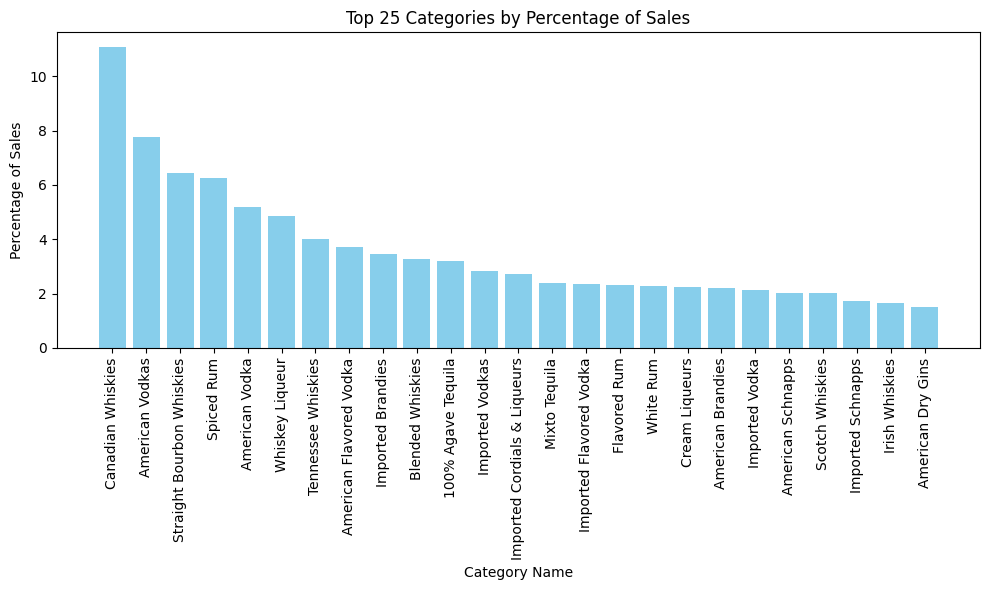

In [84]:
# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(sorted_sales_by_category_name['Category Name'], sorted_sales_by_category_name['Percentage of Sales'], color='skyblue')
plt.xlabel('Category Name')
plt.ylabel('Percentage of Sales')
plt.title('Top 25 Categories by Percentage of Sales')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

##### Top 10 Stores by Percentage of Sales

In [85]:
# Group by 'Store Name' and sum 'Sale (Dollars)'
store_sales = sales_df_aug_2016.groupby('Store Name')['Sale (Dollars)'].sum().reset_index()

# Calculate the total sales
total_sales = store_sales['Sale (Dollars)'].sum()

# Calculate the percentage of sales for each store
store_sales['Percentage of Sales'] = (store_sales['Sale (Dollars)'] / total_sales) * 100

# Display the result
sorted_sales_by_store_name = store_sales.sort_values(by='Percentage of Sales', ascending=False).head(10)

# Extract list of store names
top_store_names = sorted_sales_by_store_name['Store Name'].tolist()

# Display the result
print(top_store_names)

['Hy-Vee #3 / BDI / Des Moines', 'Central City 2', 'Hy-Vee Food Store / Coralville', 'Benz Distributing', 'Hy-Vee Wine and Spirits / Iowa City', 'Lot-A-Spirits', 'Wilkie Liquors', 'Hy-Vee / Urbandale', 'Iowa Street Market, Inc.', 'Hy-Vee Food Store #1 / Ames']


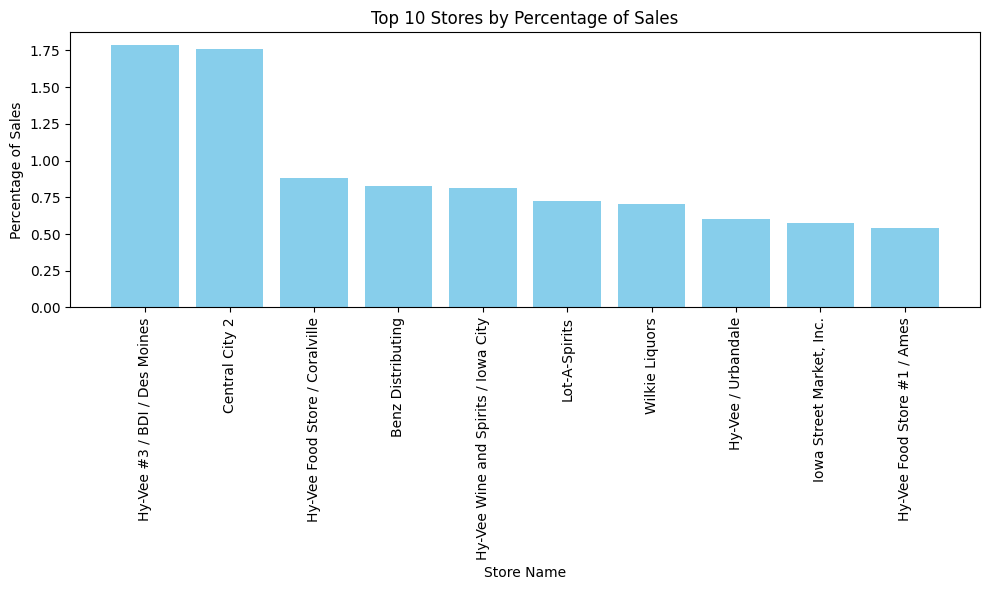

In [86]:
# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(sorted_sales_by_store_name['Store Name'], sorted_sales_by_store_name['Percentage of Sales'], color='skyblue')
plt.xlabel('Store Name')
plt.ylabel('Percentage of Sales')
plt.title('Top 10 Stores by Percentage of Sales')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [87]:
# Group by 'Date' and sum 'Bottles Sold'
daily_sales = sales_df_aug_2016.groupby('Date')['Bottles Sold'].sum().reset_index()


In [88]:
# Generate a complete date range for the DataFrame
date_range = pd.date_range(start=daily_sales['Date'].min(), end=daily_sales['Date'].max())

# Calculate missing dates
missing_dates = date_range.difference(daily_sales['Date'])

# Extract year and month from missing dates
missing_dates_year = missing_dates.year
missing_dates_month = missing_dates.month

# Create a DataFrame with missing dates, year, and month
missing_dates_df = pd.DataFrame({'Year': missing_dates_year, 'Month': missing_dates_month})

# Pivot the DataFrame
missing_dates_pivot = missing_dates_df.pivot_table(index='Month', columns='Year', aggfunc='size', fill_value=0)

# Display the result
print("Missing Days per Year and Month:")
print(missing_dates_pivot)


Missing Days per Year and Month:
Year   2016  2017
Month            
1         0    10
2         0     8
3         0     8
4         0    10
5         0     7
6         0     8
7         0    10
8         0     8
9         8     9
10       10     9
11        9     0
12        9     0


There are some missing dates in 2016 and 2017 years. we can replace the missing dates values using interpolatev method.

Interpolation methods are used to estimate values for missing data points based on the available data. Here's a short summary of common interpolation methods:

1. **Linear Interpolation**: Assumes a linear relationship between consecutive data points and estimates missing values by drawing a straight line between them.

2. **Polynomial Interpolation**: Fits a polynomial curve to the available data points and estimates missing values based on this curve. The degree of the polynomial can be adjusted.

3. **Spline Interpolation**: Fits piecewise polynomial functions to the data points, ensuring smooth transitions between adjacent intervals.

4. **Nearest Neighbor Interpolation**: Assigns the value of the nearest available data point to the missing data point.

5. **Time-based Interpolation**: Considers the time intervals between data points and estimates missing values based on the proportion of time passed between adjacent data points.

6. **Time Series Models**: Advanced techniques such as ARIMA or exponential smoothing models can be used to forecast missing values based on the historical data.

Each interpolation method has its strengths and weaknesses, and the choice depends on factors such as the characteristics of the data, the desired level of accuracy, and the underlying assumptions about the data's behavior. Experimentation and validation are often necessary to determine the most appropriate interpolation method for a specific dataset.

In [89]:
# Convert the 'Date' column to datetime type if it's not already in datetime format
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])

# Set the 'Date' column as the index
daily_sales = daily_sales.set_index('Date')

# Reindex the DataFrame to include all dates in the range
idx = pd.date_range(start=daily_sales.index.min(), end=daily_sales.index.max())
daily_sales = daily_sales.reindex(idx)

# Use linear interpolation to fill missing values
daily_sales['Bottles Sold'] = daily_sales['Bottles Sold'].interpolate(method='linear')

# Reset the index to have 'Date' as a column again
daily_sales = daily_sales.reset_index().rename(columns={'index': 'Date'})

# Display the result
daily_sales.head()


Date  Bottles Sold
0 2016-08-29       18515.0
1 2016-08-30       19924.0
2 2016-08-31       27579.0
3 2016-09-01       20775.0
4 2016-09-02       10913.0

In [90]:
daily_sales.columns

Index(['Date', 'Bottles Sold'], dtype='object')

Check missing dates after filling the values

In [91]:
# Generate a complete date range for the DataFrame
date_range = pd.date_range(start=daily_sales['Date'].min(), end=daily_sales['Date'].max())

# Calculate missing dates
missing_dates = date_range.difference(daily_sales['Date'])

# Extract year and month from missing dates
missing_dates_year = missing_dates.year
missing_dates_month = missing_dates.month

# Create a DataFrame with missing dates, year, and month
missing_dates_df = pd.DataFrame({'Year': missing_dates_year, 'Month': missing_dates_month})

# Pivot the DataFrame
missing_dates_pivot = missing_dates_df.pivot_table(index='Month', columns='Year', aggfunc='size', fill_value=0)

# Display the result
print("Missing Days per Year and Month:")
print(missing_dates_pivot)


Missing Days per Year and Month:
Empty DataFrame
Columns: []
Index: []


#### univarinat normalization and backtesting

##### daily

In [92]:

def forecast_sales(data, column_name, forecast_horizon=7, window_size=30):
    """
    Forecast sales using multiple time series models and calculate error metrics.

    Parameters:
    data (pd.DataFrame): DataFrame containing the sales data.
    column_name (str): Column name of the sales data.
    forecast_horizon (int): Number of days to forecast. Default is 7.
    window_size (int): Size of the sliding window for backtesting. Default is 30.

    Returns:
    dict: Dictionary containing error metrics and forecast values.
    """
    # Normalize the sales data column
    scaler = MinMaxScaler()
    data[column_name] = scaler.fit_transform(data[[column_name]])

    def sliding_window_forecast(data, window_size=30, forecast_horizon=7):
        """
        Generate sliding windows for backtesting.

        Parameters:
        data (pd.DataFrame): DataFrame containing the sales data.
        window_size (int): Size of the sliding window.
        forecast_horizon (int): Number of days to forecast.

        Yields:
        tuple: Tuple containing the training and test sets for each window.
        """
        train_size = len(data) - forecast_horizon
        for i in range(train_size - window_size + 1):
            train = data.iloc[i:i + window_size]
            test = data.iloc[i + window_size:i + window_size + forecast_horizon]
            yield train, test

    def calculate_errors(actual, predicted):
        """
        Calculate MAE and MSE error metrics.

        Parameters:
        actual (np.array): Array of actual values.
        predicted (np.array): Array of predicted values.

        Returns:
        tuple: Tuple containing MAE and MSE.
        """
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        return mae, mse

    def forecast_arima(train, test):
        """
        Forecast using ARIMA model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        model = ARIMA(train[column_name], order=(5, 1, 0))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        return forecast

    def forecast_sarima(train, test):
        """
        Forecast using SARIMAX model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        order = (5, 1, 0)  # (p, d, q)
        seasonal_order = (1, 1, 1, 12)
        model = SARIMAX(train[column_name], order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        forecast = model_fit.forecast(steps=len(test))
        return forecast

    def forecast_ets(train, test):
        """
        Forecast using ETS model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        model = ExponentialSmoothing(train[column_name], seasonal='add', seasonal_periods=12)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        return forecast

    def forecast_prophet(train, test):
        """
        Forecast using Prophet model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        train_prophet = train.rename(columns={'date': 'ds', column_name: 'y'})
        model = Prophet()
        model.fit(train_prophet)
        future = model.make_future_dataframe(periods=len(test))
        forecast = model.predict(future)
        return forecast['yhat'][-len(test):].values

    def forecast_lstm(train, test):
        """
        Forecast using LSTM model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        series = train[column_name].values
        generator = TimeseriesGenerator(series, series, length=10, batch_size=1)
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(10, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator, epochs=20, verbose=0)
        test_series = train[column_name].values[-10:]
        forecast = []
        for _ in range(len(test)):
            x_input = test_series[-10:].reshape((1, 10, 1))
            yhat = model.predict(x_input, verbose=0)
            forecast.append(yhat[0][0])
            test_series = np.append(test_series, yhat)
        return np.array(forecast)

    # Initialize dictionaries to store results
    forecast_dict = {}
    error_dict = {}

    # Run backtesting with sliding windows
    for train, test in sliding_window_forecast(data, window_size, forecast_horizon):
        actual = test[column_name].values

        # ARIMA model
        arima_forecast = forecast_arima(train, test)
        mae, mse = calculate_errors(actual, arima_forecast)
        error_dict.setdefault('ARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ARIMA', []).append(arima_forecast)

        # SARIMAX model
        sarima_forecast = forecast_sarima(train, test)
        mae, mse = calculate_errors(actual, sarima_forecast)
        error_dict.setdefault('SARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('SARIMA', []).append(sarima_forecast)

        # ETS model
        ets_forecast = forecast_ets(train, test)
        mae, mse = calculate_errors(actual, ets_forecast)
        error_dict.setdefault('ETS', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ETS', []).append(ets_forecast)

        # Prophet model
        prophet_forecast = forecast_prophet(train, test)
        mae, mse = calculate_errors(actual, prophet_forecast)
        error_dict.setdefault('Prophet', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('Prophet', []).append(prophet_forecast)

        # LSTM model
        lstm_forecast = forecast_lstm(train, test)
        mae, mse = calculate_errors(actual, lstm_forecast)
        error_dict.setdefault('LSTM', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('LSTM', []).append(lstm_forecast)

    # Calculate average error metrics for backtesting
    average_error_dict = {model: {'MAE': np.mean([x['MAE'] for x in errors]),
                                  'MSE': np.mean([x['MSE'] for x in errors])}
                          for model, errors in error_dict.items()}

    # Convert error metrics to DataFrame
    error_df = pd.DataFrame(average_error_dict).T
    error_df.index.name = 'Model'
    error_df.columns = ['MAE', 'MSE']

    # Initialize dictionary for final forecasts
    final_forecast_dict = {}

    def final_forecast(model_func, data, forecast_horizon):
        """
        Generate final forecast using the specified model function.

        Parameters:
        model_func (function): Forecast function for the model.
        data (pd.DataFrame): DataFrame containing the sales data.
        forecast_horizon (int): Number of days to forecast.

        Returns:
        tuple: Tuple containing forecast dates and values.
        """
        dates = pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')
        forecast = model_func(data, pd.DataFrame(index=dates))
        return dates, forecast

    # ARIMA final forecast
    final_forecast_dict['ARIMA'] = forecast_arima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')))

    # SARIMAX final forecast
    final_forecast_dict['SARIMA'] = forecast_sarima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')))

    # ETS final forecast
    final_forecast_dict['ETS'] = forecast_ets(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')))

    # Prophet final forecast
    prophet_dates, prophet_forecast = final_forecast(forecast_prophet, data, forecast_horizon)
    final_forecast_dict['Prophet'] = {'dates': prophet_dates, 'forecast': prophet_forecast}

    # LSTM final forecast
    lstm_dates, lstm_forecast = final_forecast(forecast_lstm, data, forecast_horizon)
    final_forecast_dict['LSTM'] = {'dates': lstm_dates, 'forecast': lstm_forecast}

    # Combine forecasts into a DataFrame
    forecast_df = pd.DataFrame(index=prophet_dates)

    # Add forecast values for each model and inverse transform them
    for model in final_forecast_dict:
        forecast_values = final_forecast_dict[model]
        if model in ['Prophet', 'LSTM']:
            forecast_df[model] = scaler.inverse_transform(forecast_values['forecast'].reshape(-1, 1)).flatten().astype(int)
        else:
            forecast_df[model] = scaler.inverse_transform(forecast_values.values.reshape(-1, 1)).flatten().astype(int)

    # Rename the index to 'Date'
    forecast_df.index.name = 'Date'

    # Output object
    result = {
        'error_metrics': error_df,
        'forecasts': forecast_df
    }

    return result


In [93]:
# Load the data
data = daily_sales.copy() 

# Rename the column
data.rename(columns={'Date': 'date'}, inplace=True)

# Call the function
daily_sales_forecast_result = forecast_sales(data, 'Bottles Sold')

# Print the results
print("Backtesting Error Metrics:")
print(daily_sales_forecast_result['error_metrics'])

print("Final Forecasts for the next 7 days:")
print(daily_sales_forecast_result['forecasts'])

c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
22:20:00 - cmdstanpy - INFO - Chain [1] start processing
22:20:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\U

Backtesting Error Metrics:
              MAE       MSE
Model                      
ARIMA    0.110255  0.025245
SARIMA   0.171120  0.060968
ETS      0.184652  0.053538
Prophet  0.085408  0.018304
LSTM     0.138767  0.084308
Final Forecasts for the next 7 days:
            ARIMA  SARIMA    ETS  Prophet   LSTM
Date                                            
2017-11-01  20906   20394  18652    23560  19249
2017-11-02  16840   16456  19533    20348  16343
2017-11-03  15980   15352  19143    12123  15051
2017-11-04  17225   17490  20107    15416  15686
2017-11-05  20005   20703  20244    19443  17531
2017-11-06  21101   22012  20011    23390  19445
2017-11-07  21091   22093  20061    21510  19309


##### week

In [94]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense

def forecast_week_sales(data, column_name, forecast_horizon=7, window_size=7):
    """
    Forecast sales using multiple time series models and calculate error metrics.

    Parameters:
    data (pd.DataFrame): DataFrame containing the sales data.
    column_name (str): Column name of the sales data.
    forecast_horizon (int): Number of weeks to forecast. Default is 7.
    window_size (int): Size of the sliding window for backtesting in weeks. Default is 30.

    Returns:
    dict: Dictionary containing error metrics and forecast values.
    """
    # Convert the date column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(data['date']):
        data['date'] = pd.to_datetime(data['date'])

    # Aggregate the data into weekly sums
    data.set_index('date', inplace=True)
    data = data.resample('W').sum().reset_index()

    # Normalize the sales data column
    scaler = MinMaxScaler()
    data[column_name] = scaler.fit_transform(data[[column_name]])

    def sliding_window_forecast(data, window_size=30, forecast_horizon=7):
        """
        Generate sliding windows for backtesting.

        Parameters:
        data (pd.DataFrame): DataFrame containing the sales data.
        window_size (int): Size of the sliding window.
        forecast_horizon (int): Number of weeks to forecast.

        Yields:
        tuple: Tuple containing the training and test sets for each window.
        """
        train_size = len(data) - forecast_horizon
        for i in range(train_size - window_size + 1):
            train = data.iloc[i:i + window_size]
            test = data.iloc[i + window_size:i + window_size + forecast_horizon]
            yield train, test

    def calculate_errors(actual, predicted):
        """
        Calculate MAE and MSE error metrics.

        Parameters:
        actual (np.array): Array of actual values.
        predicted (np.array): Array of predicted values.

        Returns:
        tuple: Tuple containing MAE and MSE.
        """
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        return mae, mse

    def forecast_arima(train, test):
        """
        Forecast using ARIMA model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        model = ARIMA(train[column_name], order=(5, 1, 0))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        return forecast

    def forecast_sarima(train, test):
        """
        Forecast using SARIMAX model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        try:
            order = (1, 1, 1)  # Simpler (p, d, q)
            seasonal_order = (1, 1, 1, 52)  # Keeping seasonal order same
            model = SARIMAX(train[column_name], order=order, seasonal_order=seasonal_order)
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast(steps=len(test))
            return forecast
        except np.linalg.LinAlgError:
            print("SARIMAX model fitting failed due to LinAlgError")
            return np.zeros(len(test))

    def forecast_ets(train, test):
        """
        Forecast using ETS model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        seasonal_periods = 4  # Adjusted seasonal periods
        if len(train) >= 2 * seasonal_periods:
            model = ExponentialSmoothing(train[column_name], seasonal='add', seasonal_periods=seasonal_periods)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=len(test))
            return forecast
        else:
            print("Not enough data for ETS model")
            return np.zeros(len(test))

    def forecast_prophet(train, test):
        """
        Forecast using Prophet model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        train_prophet = train.rename(columns={'date': 'ds', column_name: 'y'})
        model = Prophet()
        model.fit(train_prophet)
        future = model.make_future_dataframe(periods=len(test), freq='W')
        forecast = model.predict(future)
        return forecast['yhat'][-len(test):].values

    def forecast_lstm(train, test):
        """
        Forecast using LSTM model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        series = train[column_name].values
        if len(series) < 10:
            print("Not enough data for LSTM model")
            return np.zeros(len(test))
        generator = TimeseriesGenerator(series, series, length=10, batch_size=1)
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(10, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator, epochs=20, verbose=0)
        test_series = train[column_name].values[-10:]
        forecast = []
        for _ in range(len(test)):
            x_input = test_series[-10:].reshape((1, 10, 1))
            yhat = model.predict(x_input, verbose=0)
            forecast.append(yhat[0][0])
            test_series = np.append(test_series, yhat)
        return np.array(forecast)

    # Initialize dictionaries to store results
    forecast_dict = {}
    error_dict = {}

    # Run backtesting with sliding windows
    for train, test in sliding_window_forecast(data, window_size, forecast_horizon):
        actual = test[column_name].values

        # ARIMA model
        arima_forecast = forecast_arima(train, test)
        mae, mse = calculate_errors(actual, arima_forecast)
        error_dict.setdefault('ARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ARIMA', []).append(arima_forecast)

        # SARIMAX model
        sarima_forecast = forecast_sarima(train, test)
        mae, mse = calculate_errors(actual, sarima_forecast)
        error_dict.setdefault('SARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('SARIMA', []).append(sarima_forecast)

        # ETS model
        ets_forecast = forecast_ets(train, test)
        mae, mse = calculate_errors(actual, ets_forecast)
        error_dict.setdefault('ETS', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ETS', []).append(ets_forecast)

        # Prophet model
        prophet_forecast = forecast_prophet(train, test)
        mae, mse = calculate_errors(actual, prophet_forecast)
        error_dict.setdefault('Prophet', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('Prophet', []).append(prophet_forecast)

        # LSTM model
        lstm_forecast = forecast_lstm(train, test)
        mae, mse = calculate_errors(actual, lstm_forecast)
        error_dict.setdefault('LSTM', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('LSTM', []).append(lstm_forecast)

    # Calculate average error metrics for backtesting
    average_error_dict = {model: {'MAE': np.mean([x['MAE'] for x in errors]),
                                  'MSE': np.mean([x['MSE'] for x in errors])}
                          for model, errors in error_dict.items()}

    # Convert error metrics to DataFrame
    error_df = pd.DataFrame(average_error_dict).T
    error_df.index.name = 'Model'
    error_df.columns = ['MAE', 'MSE']

    # Initialize dictionary for final forecasts
    final_forecast_dict = {}

    def final_forecast(model_func, data, forecast_horizon):
        """
        Generate final forecast using the specified model function.

        Parameters:
        model_func (function): Forecast function for the model.
        data (pd.DataFrame): DataFrame containing the sales data.
        forecast_horizon (int): Number of weeks to forecast.

        Returns:
        tuple: Tuple containing forecast dates and values.
        """
        dates = pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')
        forecast = model_func(data, pd.DataFrame(index=dates))
        return dates, forecast

    # ARIMA final forecast
    final_forecast_dict['ARIMA'] = forecast_arima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')))

    # SARIMAX final forecast
    final_forecast_dict['SARIMA'] = forecast_sarima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')))

    # ETS final forecast
    final_forecast_dict['ETS'] = forecast_ets(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')))

    # Prophet final forecast
    prophet_dates, prophet_forecast = final_forecast(forecast_prophet, data, forecast_horizon)
    final_forecast_dict['Prophet'] = {'dates': prophet_dates, 'forecast': prophet_forecast}

    # LSTM final forecast
    lstm_dates, lstm_forecast = final_forecast(forecast_lstm, data, forecast_horizon)
    final_forecast_dict['LSTM'] = {'dates': lstm_dates, 'forecast': lstm_forecast}

    # Combine forecasts into a DataFrame
    forecast_df = pd.DataFrame(index=prophet_dates)

    # Add forecast values for each model and inverse transform them
    for model in final_forecast_dict:
        forecast_values = final_forecast_dict[model]
        if model in ['Prophet', 'LSTM']:
            forecast_df[model] = scaler.inverse_transform(forecast_values['forecast'].reshape(-1, 1)).flatten().astype(int)
        else:
            forecast_df[model] = scaler.inverse_transform(forecast_values.values.reshape(-1, 1)).flatten().astype(int)

    # Rename the index to 'Date'
    forecast_df.index.name = 'Date'

    # Output object
    result = {
        'error_metrics': error_df,
        'forecasts': forecast_df
    }

    return result


In [95]:
# Load the data
data = daily_sales.copy() 

# Rename the column
data.rename(columns={'Date': 'date'}, inplace=True)

# Call the function
week_sales_forecast_result = forecast_week_sales(data, 'Bottles Sold')

# Print the results
print("Backtesting Error Metrics:")
print(week_sales_forecast_result['error_metrics'])

print("Final Forecasts for every week:")
print(week_sales_forecast_result['forecasts'])

c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:49:51 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:49:51 - cmdstanpy - INFO - Chain [1] done processing


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:49:51 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:49:51 - cmdstanpy - INFO - Chain [1] done processing


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:49:52 - cmdstanpy - INFO - Chain [1] start processing
22:49:52 - cmdstanpy - INFO - Chain [1] done processin

Not enough data for ETS model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:49:52 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:49:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sar

Not enough data for LSTM model


22:49:53 - cmdstanpy - INFO - Chain [1] start processing
22:49:53 - cmdstanpy - INFO - Chain [1] done processing


Not enough data for ETS model
Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:49:53 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:49:53 - cmdstanpy - INFO - Chain [1] done processing


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:49:54 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:49:54 - cmdstanpy - INFO - Chain [1] done processing


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:49:54 - cmdstanpy - INFO - Chain [1] start processing
22:49:54 - cmdstanpy - INFO - Chain [1] done processin

Not enough data for ETS model
Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:49:55 - cmdstanpy - INFO - Chain [1] start processing
22:49:55 - cmdstanpy - INFO - Chain [1] done processin

Not enough data for ETS model
Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:49:55 - cmdstanpy - INFO - Chain [1] start processing
22:49:55 - cmdstanpy - INFO - Chain [1] done processin

Not enough data for ETS model
Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:49:56 - cmdstanpy - INFO - Chain [1] start processing
22:49:56 - cmdstanpy - INFO - Chain [1] done processin

Not enough data for ETS model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:49:56 - cmdstanpy - INFO - Chain [1] start processing
22:49:56 - cmdstanpy - INFO - Chain [1] done processin

Not enough data for ETS model
Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:49:57 - cmdstanpy - INFO - Chain [1] start processing
22:49:57 - cmdstanpy - INFO - Chain [1] done processin

Not enough data for ETS model
Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:49:57 - cmdstanpy - INFO - Chain [1] start processing
22:49:57 - cmdstanpy - INFO - Chain [1] done processin

Not enough data for ETS model
Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:49:58 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:49:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:49:58 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:49:58 - cmdstanpy - INFO - Chain [1] done processing


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:49:59 - cmdstanpy - INFO - Chain [1] start processing
22:49:59 - cmdstanpy - INFO - Chain [1] done processin

Not enough data for ETS model
Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:49:59 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:49:59 - cmdstanpy - INFO - Chain [1] done processing


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:00 - cmdstanpy - INFO - Chain [1] start processing
22:50:00 - cmdstanpy - INFO - Chain [1] done processin

Not enough data for ETS model
Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:00 - cmdstanpy - INFO - Chain [1] start processing
22:50:00 - cmdstanpy - INFO - Chain [1] done processin

Not enough data for ETS model
Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:01 - cmdstanpy - INFO - Chain [1] start processing
22:50:01 - cmdstanpy - INFO - Chain [1] done processin

Not enough data for ETS model
Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:01 - cmdstanpy - INFO - Chain [1] start processing
22:50:01 - cmdstanpy - INFO - Chain [1] done processin

Not enough data for ETS model
Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:02 - cmdstanpy - INFO - Chain [1] start processing
22:50:02 - cmdstanpy - INFO - Chain [1] done processing


Not enough data for ETS model
Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:02 - cmdstanpy - INFO - Chain [1] start processing
22:50:02 - cmdstanpy - INFO - Chain [1] done processing


Not enough data for ETS model
Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:03 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:50:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:04 - cmdstanpy - INFO - Chain [1] start processing
22:50:04 - cmdstanpy - INFO - Chain [1] done processin

Not enough data for ETS model
Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:04 - cmdstanpy - INFO - Chain [1] start processing
22:50:04 - cmdstanpy - INFO - Chain [1] done processin

Not enough data for ETS model
Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:05 - cmdstanpy - INFO - Chain [1] start processing
22:50:05 - cmdstanpy - INFO - Chain [1] done processin

Not enough data for ETS model
Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:05 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:50:05 - cmdstanpy - INFO - Chain [1] done processing


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:05 - cmdstanpy - INFO - Chain [1] start processing
22:50:06 - cmdstanpy - INFO - Chain [1] done processing


Not enough data for ETS model
Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:06 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:50:06 - cmdstanpy - INFO - Chain [1] done processing


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:07 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:50:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Not enough data for LSTM model


22:50:07 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:50:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:08 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:50:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:08 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:50:08 - cmdstanpy - INFO - Chain [1] done processing


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:09 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:50:09 - cmdstanpy - INFO - Chain [1] done processing


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:09 - cmdstanpy - INFO - Chain [1] start processing
22:50:09 - cmdstanpy - INFO - Chain [1] done processin

Not enough data for ETS model
Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:10 - cmdstanpy - INFO - Chain [1] start processing
22:50:10 - cmdstanpy - INFO - Chain [1] done processin

Not enough data for ETS model
Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:10 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:50:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:11 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:50:11 - cmdstanpy - INFO - Chain [1] done processing


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:11 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:50:11 - cmdstanpy - INFO - Chain [1] done processing


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:12 - cmdstanpy - INFO - Chain [1] start processing
22:50:12 - cmdstanpy - INFO - Chain [1] done processin

Not enough data for ETS model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Not enough data for LSTM model


22:50:12 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:50:12 - cmdstanpy - INFO - Chain [1] done processing


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:13 - cmdstanpy - INFO - Chain [1] start processing
22:50:13 - cmdstanpy - INFO - Chain [1] done processin

Not enough data for ETS model
Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:14 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:50:14 - cmdstanpy - INFO - Chain [1] done processing


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:14 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:50:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sar

Not enough data for LSTM model


22:50:15 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:50:15 - cmdstanpy - INFO - Chain [1] done processing


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:15 - cmdstanpy - INFO - Chain [1] start processing
22:50:15 - cmdstanpy - INFO - Chain [1] done processin

Not enough data for ETS model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:16 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:50:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Not enough data for LSTM model


22:50:20 - cmdstanpy - INFO - Chain [1] start processing
22:50:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Backtesting Error Metrics:
              MAE       MSE
Model                      
ARIMA    0.152277  0.053446
SARIMA   0.099803  0.020112
ETS      0.619524  0.394662
Prophet  0.145684  0.044815
LSTM     0.619524  0.394662
Final Forecasts for every week:
             ARIMA  SARIMA    ETS  Prophet    LSTM
Date                                              
2017-11-12   63425   50658  87863   128079  129216
2017-11-19  104137   70336  89953   127933  131322
2017-11-26   84546   56905  91824   127787  132998
2017-12-03  109937   55244  84018   127642  133924
2017-12-10   93481   47044  87863   127496  135140
2017-12-17   66043   62537  89953   127350  136247
2017-12-24   96317   90846  91824   127204  136849


##### month

In [96]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense

def forecast_monthly_sales(data, column_name, forecast_horizon=6, window_size=6):
    """
    Forecast sales using multiple time series models and calculate error metrics.

    Parameters:
    data (pd.DataFrame): DataFrame containing the sales data.
    column_name (str): Column name of the sales data.
    forecast_horizon (int): Number of months to forecast. Default is 6.
    window_size (int): Size of the sliding window for backtesting in months. Default is 6.

    Returns:
    dict: Dictionary containing error metrics and forecast values.
    """
    # Convert the date column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(data['date']):
        data['date'] = pd.to_datetime(data['date'])

    # Aggregate the data into monthly sums
    data.set_index('date', inplace=True)
    data = data.resample('MS').sum().reset_index()

    # Normalize the sales data column
    scaler = MinMaxScaler()
    data[column_name] = scaler.fit_transform(data[[column_name]])

    def sliding_window_forecast(data, window_size=6, forecast_horizon=6):
        """
        Generate sliding windows for backtesting.

        Parameters:
        data (pd.DataFrame): DataFrame containing the sales data.
        window_size (int): Size of the sliding window.
        forecast_horizon (int): Number of months to forecast.

        Yields:
        tuple: Tuple containing the training and test sets for each window.
        """
        train_size = len(data) - forecast_horizon
        cumulative_length = 0  # Initialize cumulative length counter

        for i in range(train_size - window_size + 1):
            train = data.iloc[i:i + window_size]
            test = data.iloc[i + window_size:i + window_size + forecast_horizon]
            cumulative_length += len(train)
            print(f"Length of training data in iteration {i+1}: {len(train)}, Cumulative length: {cumulative_length}")
            yield train, test

    def calculate_errors(actual, predicted):
        """
        Calculate MAE and MSE error metrics.

        Parameters:
        actual (np.array): Array of actual values.
        predicted (np.array): Array of predicted values.

        Returns:
        tuple: Tuple containing MAE and MSE.
        """
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        return mae, mse

    def forecast_arima(train, test):
        """
        Forecast using ARIMA model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        model = ARIMA(train[column_name], order=(5, 1, 0))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        return forecast

    def forecast_sarima(train, test):
        """
        Forecast using SARIMAX model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        try:
            order = (1, 1, 1)  # Simpler (p, d, q)
            seasonal_order = (1, 1, 1, 12)  # Monthly seasonality
            model = SARIMAX(train[column_name], order=order, seasonal_order=seasonal_order)
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast(steps=len(test))
            return forecast
        except np.linalg.LinAlgError:
            print("SARIMAX model fitting failed due to LinAlgError")
            return np.zeros(len(test))

    def forecast_ets(train, test):
        """
        Forecast using ETS model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        seasonal_periods = 12  # Monthly seasonality
        if len(train) >= 2 * seasonal_periods:
            model = ExponentialSmoothing(train[column_name], seasonal='add', seasonal_periods=seasonal_periods)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=len(test))
            return forecast
        else:
            print("Not enough data for ETS model")
            return np.zeros(len(test))

    def forecast_prophet(train, test):
        """
        Forecast using Prophet model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        train_prophet = train.rename(columns={'date': 'ds', column_name: 'y'})
        model = Prophet()
        model.fit(train_prophet)
        future = model.make_future_dataframe(periods=len(test), freq='MS')
        forecast = model.predict(future)
        return forecast['yhat'][-len(test):].values

    def forecast_lstm(train, test):
        """
        Forecast using LSTM model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        series = train[column_name].values
        if len(series) < 10:
            print("Not enough data for LSTM model")
            return np.zeros(len(test))
        generator = TimeseriesGenerator(series, series, length=10, batch_size=1)
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(10, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator, epochs=20, verbose=0)
        test_series = train[column_name].values[-10:]
        forecast = []
        for _ in range(len(test)):
            x_input = test_series[-10:].reshape((1, 10, 1))
            yhat = model.predict(x_input, verbose=0)
            forecast.append(yhat[0][0])
            test_series = np.append(test_series, yhat)
        return np.array(forecast)

    # Initialize dictionaries to store results
    forecast_dict = {}
    error_dict = {}

    # Run backtesting with sliding windows
    for train, test in sliding_window_forecast(data, window_size, forecast_horizon):
        actual = test[column_name].values

        # ARIMA model
        arima_forecast = forecast_arima(train, test)
        mae, mse = calculate_errors(actual, arima_forecast)
        error_dict.setdefault('ARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ARIMA', []).append(arima_forecast)

        # SARIMAX model
        sarima_forecast = forecast_sarima(train, test)
        mae, mse = calculate_errors(actual, sarima_forecast)
        error_dict.setdefault('SARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('SARIMA ', []).append(sarima_forecast)

        # ETS model
        ets_forecast = forecast_ets(train, test)
        mae, mse = calculate_errors(actual, ets_forecast)
        error_dict.setdefault('ETS', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ETS', []).append(ets_forecast)

        # Prophet model
        prophet_forecast = forecast_prophet(train, test)
        mae, mse = calculate_errors(actual, prophet_forecast)
        error_dict.setdefault('Prophet', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('Prophet', []).append(prophet_forecast)

        # LSTM model
        lstm_forecast = forecast_lstm(train, test)
        mae, mse = calculate_errors(actual, lstm_forecast)
        error_dict.setdefault('LSTM', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('LSTM', []).append(lstm_forecast)

    # Calculate average error metrics for backtesting
    average_error_dict = {model: {'MAE': np.mean([x['MAE'] for x in errors]),
                                  'MSE': np.mean([x['MSE'] for x in errors])}
                          for model, errors in error_dict.items()}

    # Convert error metrics to DataFrame
    error_df = pd.DataFrame(average_error_dict).T
    error_df.index.name = 'Model'
    error_df.columns = ['MAE', 'MSE']

    # Initialize dictionary for final forecasts
    final_forecast_dict = {}

    def final_forecast(model_func, data, forecast_horizon):
        """
        Generate final forecast using the specified model function.

        Parameters:
        model_func (function): Forecast function for the model.
        data (pd.DataFrame): DataFrame containing the sales data.
        forecast_horizon (int): Number of months to forecast.

        Returns:
        tuple: Tuple containing forecast dates and values.
        """
        dates = pd.date_range(start=data['date'].iloc[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')
        forecast = model_func(data, pd.DataFrame(index=dates))
        return dates, forecast

    # ARIMA final forecast
    final_forecast_dict['ARIMA'] = forecast_arima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')))

    # SARIMAX final forecast
    final_forecast_dict['SARIMA'] = forecast_sarima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')))

    # ETS final forecast
    final_forecast_dict['ETS'] = forecast_ets(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')))

    # Prophet final forecast
    prophet_dates, prophet_forecast = final_forecast(forecast_prophet, data, forecast_horizon)
    final_forecast_dict['Prophet'] = {'dates': prophet_dates, 'forecast': prophet_forecast}

    # LSTM final forecast
    lstm_dates, lstm_forecast = final_forecast(forecast_lstm, data, forecast_horizon)
    final_forecast_dict['LSTM'] = {'dates': lstm_dates, 'forecast': lstm_forecast}

    # Combine forecasts into a DataFrame
    forecast_df = pd.DataFrame(index=prophet_dates)

    # Add forecast values for each model and inverse transform them
    for model in final_forecast_dict:
        forecast_values = final_forecast_dict[model]
        if model in ['Prophet', 'LSTM']:
            forecast_df[model] = scaler.inverse_transform(forecast_values['forecast'].reshape(-1, 1)).flatten().astype(int)
        else:
            if isinstance(forecast_values, np.ndarray):
                forecast_df[model] = scaler.inverse_transform(forecast_values.reshape(-1, 1)).flatten().astype(int)
            else:
                forecast_df[model] = scaler.inverse_transform(forecast_values.values.reshape(-1, 1)).flatten().astype(int)

    # Rename the index to 'Date'
    forecast_df.index.name = 'Date'

    # Output object
    result = {
        'error_metrics': error_df,
        'forecasts': forecast_df
    }

    return result


In [97]:
# Load the data
data = daily_sales.copy() 

# Rename the column
data.rename(columns={'Date': 'date'}, inplace=True)

# Call the function
monthly_sales_result = forecast_monthly_sales(data, 'Bottles Sold')

# Print the results
print("Backtesting Error Metrics:")
print(monthly_sales_result['error_metrics'])

print("Final Forecasts for the every month:")
print(monthly_sales_result['forecasts'])

Length of training data in iteration 1: 6, Cumulative length: 6


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866:

Not enough data for ETS model


22:50:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Not enough data for LSTM model
Length of training data in iteration 2: 6, Cumulative length: 12


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:28 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:50:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Not enough data for LSTM model
Length of training data in iteration 3: 6, Cumulative length: 18


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:28 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:50:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Not enough data for LSTM model
Length of training data in iteration 4: 6, Cumulative length: 24


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:28 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:50:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Not enough data for LSTM model


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
22:50:29 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


22:50:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Backtesting Error Metrics:
              MAE       MSE
Model                      
ARIMA    1.048879  2.989307
SARIMA   0.088116  0.009944
ETS      0.807075  0.654106
Prophet  0.297157  0.136743
LSTM     0.807075  0.654106
Final Forecasts for the every month:
             ARIMA  SARIMA    ETS  Prophet    LSTM
Date                                              
2017-11-01  669315  638029  66018   653734  595860
2017-12-01  636345  736627  66018   666659  605589
2018-01-01  712953  548752  66018   680016  617189
2018-02-01  669757  531814  66018   693373  624289
2018-03-01  627526  587539  66018   705437  632575
2018-04-01  665017  582073  66018   718794  638867


#### Multi variant timeseries 

In [98]:
print(top_catgories_names)
print(top_store_names)

['Canadian Whiskies', 'American Vodkas', 'Straight Bourbon Whiskies', 'Spiced Rum', 'American Vodka', 'Whiskey Liqueur', 'Tennessee Whiskies', 'American Flavored Vodka', 'Imported Brandies', 'Blended Whiskies', '100% Agave Tequila', 'Imported Vodkas', 'Imported Cordials & Liqueurs', 'Mixto Tequila', 'Imported Flavored Vodka', 'Flavored Rum', 'White Rum', 'Cream Liqueurs', 'American Brandies', 'Imported Vodka', 'American Schnapps', 'Scotch Whiskies', 'Imported Schnapps', 'Irish Whiskies', 'American Dry Gins']
['Hy-Vee #3 / BDI / Des Moines', 'Central City 2', 'Hy-Vee Food Store / Coralville', 'Benz Distributing', 'Hy-Vee Wine and Spirits / Iowa City', 'Lot-A-Spirits', 'Wilkie Liquors', 'Hy-Vee / Urbandale', 'Iowa Street Market, Inc.', 'Hy-Vee Food Store #1 / Ames']


In [99]:
sales_df_aug_2016.head()

Date  Store Number                      Store Name   Category  \
9705096 2016-08-29          4509                 A J'S LIQUOR II  1031000.0   
9705185 2016-08-29          4754      Walgreens #12148 / Waverly  1081200.0   
9705587 2016-08-29          2539  Hy-Vee Food Store / iowa Falls  1041300.0   
9705691 2016-08-29          2651                Hy-Vee / Waverly  1031000.0   
9705927 2016-08-29          2651                Hy-Vee / Waverly  1031000.0   

              Category Name  Item Number  Bottles Sold  Sale (Dollars)  
9705096      American Vodka        38006             1          148.56  
9705185      Cream Liqueurs        73055             1          225.00  
9705587  American Sloe Gins        33717             2            8.13  
9705691      American Vodka        37417             1           99.00  
9705927      American Vodka        37336             2            9.75

#### Vector Autoregression (VAR) model

##### Top stores

In [100]:
# Filter the DataFrame using top_store_names list
filtered_daily_sales = sales_df_aug_2016[sales_df_aug_2016['Store Name'].isin(top_store_names)]

# Group by 'Date' and 'Store Name', and sum 'Bottles Sold'
daily_store_sales = filtered_daily_sales.groupby(['Date', 'Store Name'])['Bottles Sold'].sum().reset_index()

# Display the result
daily_store_sales.head()

Date                      Store Name  Bottles Sold
0 2016-08-29               Benz Distributing           173
1 2016-08-29                  Central City 2           414
2 2016-08-29    Hy-Vee #3 / BDI / Des Moines           491
3 2016-08-29  Hy-Vee Food Store / Coralville           208
4 2016-08-29                   Lot-A-Spirits           139

In [101]:
# Pivot the DataFrame
pivot_df = daily_store_sales.pivot_table(index='Date', columns='Store Name', values='Bottles Sold', fill_value=0)

# Reset the index
pivot_df.reset_index(inplace=True)

# Display the modified DataFrame
pivot_df.head()

Store Name       Date  Benz Distributing  Central City 2  \
0          2016-08-29              173.0           414.0   
1          2016-08-30                0.0            50.0   
2          2016-08-31              169.0            38.0   
3          2016-09-01                0.0           810.0   
4          2016-09-03              160.0             0.0   

Store Name  Hy-Vee #3 / BDI / Des Moines  Hy-Vee / Urbandale  \
0                                  491.0                 0.0   
1                                   53.0                 0.0   
2                                    1.0                 0.0   
3                                  666.0               190.0   
4                                  208.0                 0.0   

Store Name  Hy-Vee Food Store #1 / Ames  Hy-Vee Food Store / Coralville  \
0                                   0.0                           208.0   
1                                   0.0                             0.0   
2                                 631.0                           262.0   
3                                   0.0                             0.0   
4                                   0.0                           337.0   

Store Name  Hy-Vee Wine and Spirits / Iowa City  Iowa Street Market, Inc.  \
0                                           0.0                       0.0   
1                                         559.0                     312.0   
2                                         127.0                       0.0   
3                                          39.0                       0.0   
4                                        1026.0                       0.0   

Store Name  Lot-A-Spirits  Wilkie Liquors  
0                   139.0            64.0  
1                     0.0             0.0  
2                     0.0             0.0  
3                   135.0           376.0  
4                   172.0            18.0

In [102]:
# Step 1: Prepare the data
# Assuming your DataFrame is already in the correct format with 'date' as the index and relevant columns
data = pivot_df.set_index('Date')  # pivot_df restricted_df

# Step 2: Fit VAR model
model = VAR(data)

# Choose the order of the VAR model
order = 1  # Adjust as needed
results = model.fit(order)

# Step 3: Forecast future values for the next 7 days
forecast = results.forecast(data.values[-order:], steps=7)

# Step 4: Create a DataFrame with forecasted dates and sales values
forecast_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')
forecast_df = pd.DataFrame(forecast.round().astype(int), index=forecast_dates, columns=data.columns)

# Step 5: Calculate error metrics
# Get actual values for the forecast period
actual_values = data.iloc[-7:]

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, forecast_df)
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, forecast_df)

# Display error metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

# Step 6: Concatenate the original DataFrame with the forecasted DataFrame
combined_df = pd.concat([data, forecast_df])

# Display the combined DataFrame with forecasted dates and sales values
combined_df.tail(10)


Mean Absolute Error (MAE): 162.54285714285714
Mean Squared Error (MSE): 61798.77142857143


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Store Name  Benz Distributing  Central City 2  Hy-Vee #3 / BDI / Des Moines  \
2017-10-26                0.0           617.0                         428.0   
2017-10-30              168.0           381.0                         859.0   
2017-10-31                0.0            24.0                           5.0   
2017-11-01              154.0            42.0                          31.0   
2017-11-02                9.0           579.0                         655.0   
2017-11-03               29.0            58.0                          46.0   
2017-11-04              143.0           343.0                         400.0   
2017-11-05               31.0            82.0                          62.0   
2017-11-06              117.0           156.0                         165.0   
2017-11-07               25.0           431.0                         483.0   

Store Name  Hy-Vee / Urbandale  Hy-Vee Food Store #1 / Ames  \
2017-10-26                26.0                          0.0   
2017-10-30                 0.0                          0.0   
2017-10-31               177.0                          0.0   
2017-11-01                10.0                        516.0   
2017-11-02               167.0                        -14.0   
2017-11-03                 0.0                         13.0   
2017-11-04                35.0                         32.0   
2017-11-05               136.0                         92.0   
2017-11-06                37.0                        347.0   
2017-11-07               124.0                          8.0   

Store Name  Hy-Vee Food Store / Coralville  \
2017-10-26                             0.0   
2017-10-30                           181.0   
2017-10-31                             0.0   
2017-11-01                           229.0   
2017-11-02                             6.0   
2017-11-03                            37.0   
2017-11-04                           214.0   
2017-11-05                            43.0   
2017-11-06                           172.0   
2017-11-07                            32.0   

Store Name  Hy-Vee Wine and Spirits / Iowa City  Iowa Street Market, Inc.  \
2017-10-26                                  0.0                       0.0   
2017-10-30                                596.0                       0.0   
2017-10-31                                  0.0                     358.0   
2017-11-01                                142.0                     -10.0   
2017-11-02                                 30.0                       8.0   
2017-11-03                                 98.0                      18.0   
2017-11-04                                465.0                      63.0   
2017-11-05                                 45.0                     240.0   
2017-11-06                                139.0                       5.0   
2017-11-07                                 77.0                      30.0   

Store Name  Lot-A-Spirits  Wilkie Liquors  
2017-10-26            1.0           373.0  
2017-10-30          159.0            44.0  
2017-10-31            0.0             0.0  
2017-11-01          156.0             2.0  
2017-11-02           10.0           353.0  
2017-11-03           28.0            -5.0  
2017-11-04          140.0            50.0  
2017-11-05           33.0            25.0  
2017-11-06          118.0            66.0  
2017-11-07           26.0           242.0

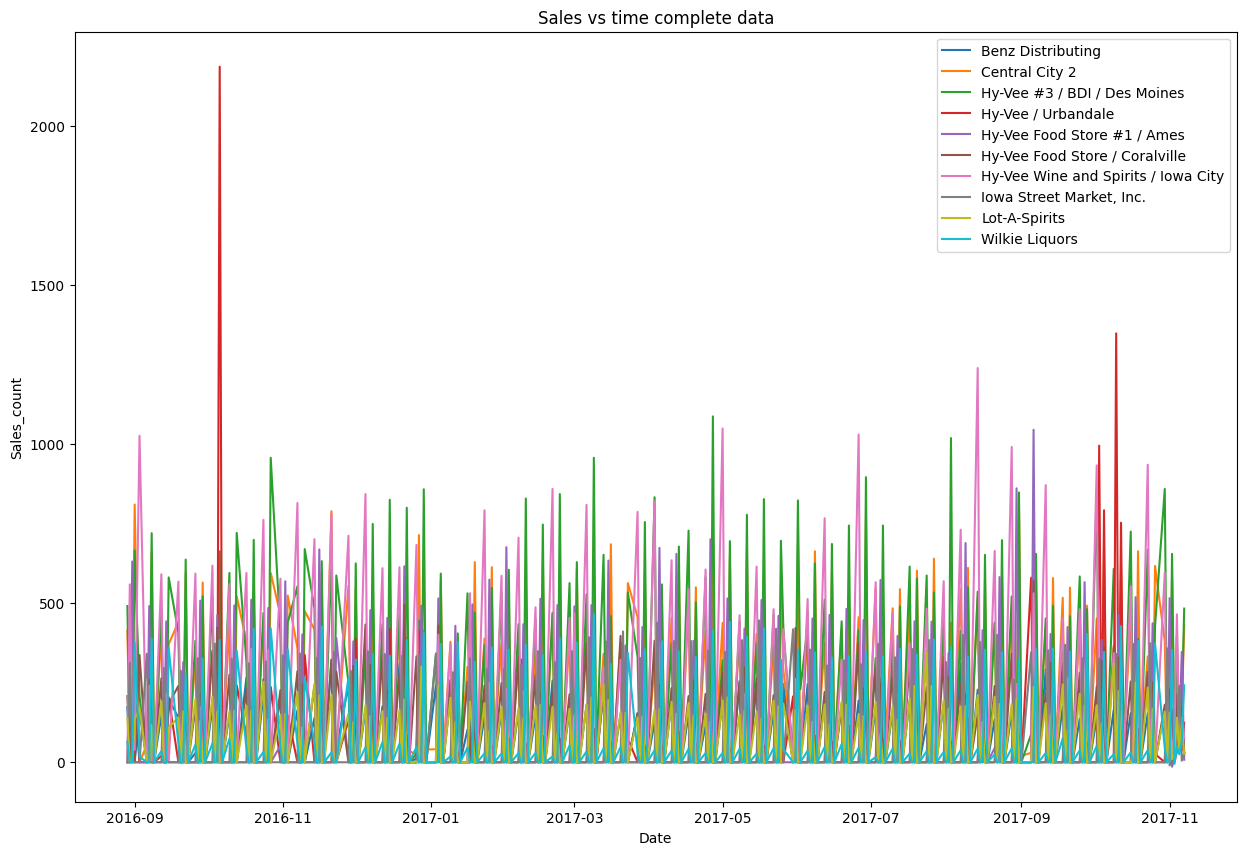

In [103]:
# Plotting the lines
plt.figure(figsize=(15, 10))
for col in combined_df.columns:
    plt.plot(combined_df.index, combined_df[col], label=col)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Sales_count')
plt.title('Sales vs time complete data')
plt.legend()
plt.show()

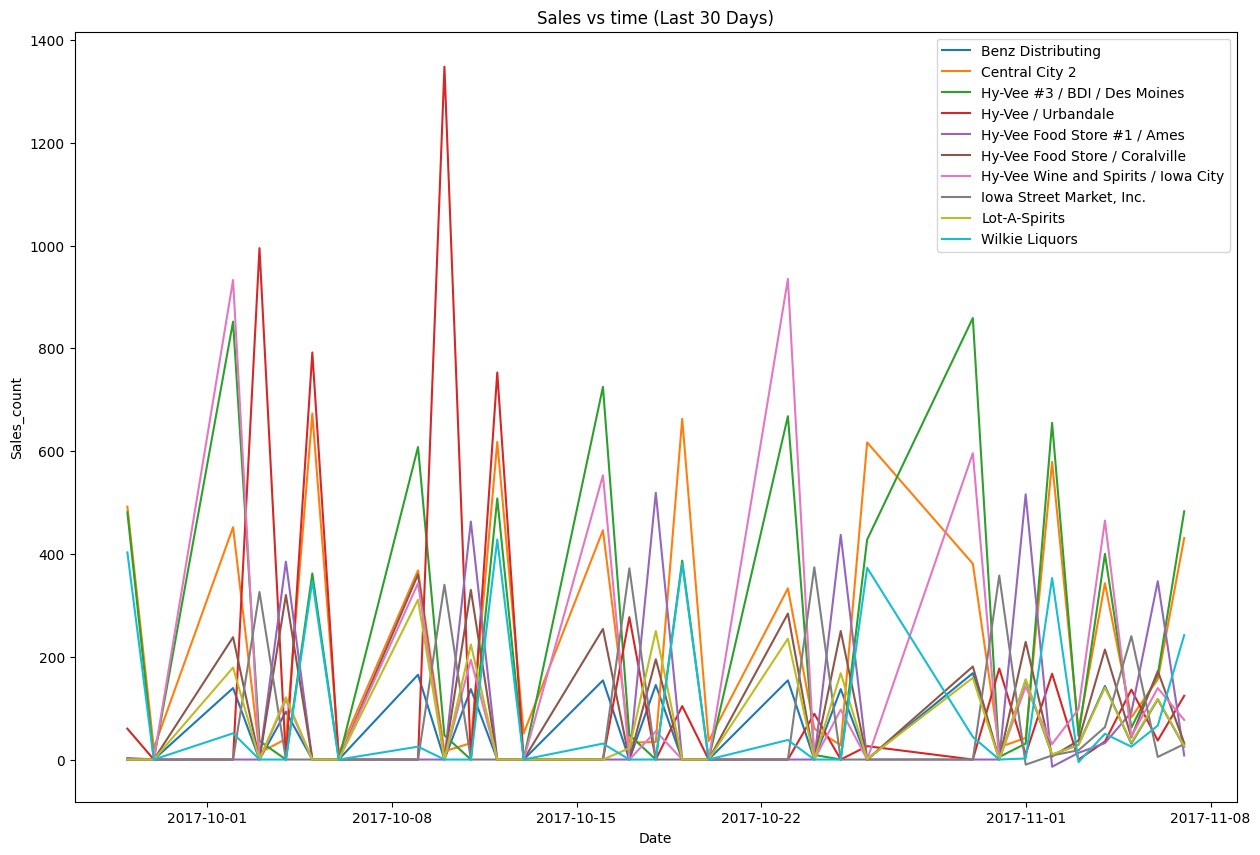

In [104]:
# Slice the DataFrame to include only the last 15 days
last_30_days_df = combined_df.iloc[-30:]

# Plotting the lines for the last 30 days
plt.figure(figsize=(15, 10))
for col in last_30_days_df.columns:
    plt.plot(last_30_days_df.index, last_30_days_df[col], label=col)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Sales_count')
plt.title('Sales vs time (Last 30 Days)')
plt.legend()
plt.show()


##### top_catgories

In [105]:
sales_df_aug_2016.head()

Date  Store Number                      Store Name   Category  \
9705096 2016-08-29          4509                 A J'S LIQUOR II  1031000.0   
9705185 2016-08-29          4754      Walgreens #12148 / Waverly  1081200.0   
9705587 2016-08-29          2539  Hy-Vee Food Store / iowa Falls  1041300.0   
9705691 2016-08-29          2651                Hy-Vee / Waverly  1031000.0   
9705927 2016-08-29          2651                Hy-Vee / Waverly  1031000.0   

              Category Name  Item Number  Bottles Sold  Sale (Dollars)  
9705096      American Vodka        38006             1          148.56  
9705185      Cream Liqueurs        73055             1          225.00  
9705587  American Sloe Gins        33717             2            8.13  
9705691      American Vodka        37417             1           99.00  
9705927      American Vodka        37336             2            9.75

In [106]:
# Filter the DataFrame using top_store_names list
filtered_daily_sales = sales_df_aug_2016[sales_df_aug_2016['Category Name'].isin(top_catgories_names)]

# Group by 'Date' and 'Category Name', and sum 'Bottles Sold'
daily_sales_category = filtered_daily_sales.groupby(['Date', 'Category Name'])['Bottles Sold'].sum().reset_index()

# Display the result
daily_sales_category.head()

Date            Category Name  Bottles Sold
0 2016-08-29       100% Agave Tequila           289
1 2016-08-29        American Brandies           719
2 2016-08-29        American Dry Gins           389
3 2016-08-29  American Flavored Vodka          1042
4 2016-08-29        American Schnapps           670

In [107]:
# Pivot the DataFrame
pivot_df = daily_sales_category.pivot_table(index='Date', columns='Category Name', values='Bottles Sold', fill_value=0)

# Reset the index
pivot_df.reset_index(inplace=True)

# Display the modified DataFrame
pivot_df.head()

Category Name       Date  100% Agave Tequila  American Brandies  \
0             2016-08-29               289.0              719.0   
1             2016-08-30               414.0              802.0   
2             2016-08-31               631.0              863.0   
3             2016-09-01               454.0              721.0   
4             2016-09-02               152.0              380.0   

Category Name  American Dry Gins  American Flavored Vodka  American Schnapps  \
0                          389.0                   1042.0              670.0   
1                          530.0                   1190.0              502.0   
2                          617.0                   1708.0              941.0   
3                          417.0                   1122.0              613.0   
4                          191.0                    614.0              361.0   

Category Name  American Vodka  American Vodkas  Blended Whiskies  \
0                      2758.0              0.0             837.0   
1                      3783.0              0.0             704.0   
2                      4429.0              0.0            1072.0   
3                      3783.0              0.0             558.0   
4                      1616.0              0.0             397.0   

Category Name  Canadian Whiskies  Cream Liqueurs  Flavored Rum  \
0                         1863.0           315.0         378.0   
1                         1911.0           278.0         434.0   
2                         2803.0           500.0         733.0   
3                         2610.0           307.0         484.0   
4                         1508.0           177.0         270.0   

Category Name  Imported Brandies  Imported Cordials & Liqueurs  \
0                          308.0                         453.0   
1                          545.0                         393.0   
2                          472.0                         696.0   
3                          411.0                         433.0   
4                          170.0                         286.0   

Category Name  Imported Flavored Vodka  Imported Schnapps  Imported Vodka  \
0                                351.0              335.0           779.0   
1                                464.0              264.0           860.0   
2                                729.0              406.0          1018.0   
3                                399.0              202.0           780.0   
4                                221.0              135.0           495.0   

Category Name  Imported Vodkas  Irish Whiskies  Mixto Tequila  \
0                          0.0           130.0          458.0   
1                          0.0           225.0          427.0   
2                          0.0           229.0          614.0   
3                          0.0           237.0          522.0   
4                          0.0           122.0          292.0   

Category Name  Scotch Whiskies  Spiced Rum  Straight Bourbon Whiskies  \
0                        249.0      1206.0                      968.0   
1                        256.0      1182.0                     1016.0   
2                        479.0      1553.0                     1517.0   
3                        320.0      1397.0                      995.0   
4                        190.0       613.0                      604.0   

Category Name  Tennessee Whiskies  Whiskey Liqueur  White Rum  
0                           813.0           1033.0      455.0  
1                           674.0            984.0      407.0  
2                           742.0           1408.0      753.0  
3                           586.0           1038.0      531.0  
4                           372.0            596.0      231.0

In [108]:
# Step 1: Prepare the data
# Assuming your DataFrame is already in the correct format with 'date' as the index and relevant columns
data = pivot_df.set_index('Date')  # pivot_df restricted_df

# Step 2: Fit VAR model
model = VAR(data)

# Choose the order of the VAR model
order = 1  # Adjust as needed
results = model.fit(order)

# Step 3: Forecast future values for the next 7 days
forecast = results.forecast(data.values[-order:], steps=7)

# Step 4: Create a DataFrame with forecasted dates and sales values
forecast_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')
forecast_df = pd.DataFrame(forecast.round().astype(int), index=forecast_dates, columns=data.columns)

# Step 5: Calculate error metrics
# Get actual values for the forecast period
actual_values = data.iloc[-7:]

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, forecast_df)
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, forecast_df)

# Display error metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

# Step 6: Concatenate the original DataFrame with the forecasted DataFrame
combined_df = pd.concat([data, forecast_df])

# Display the combined DataFrame with forecasted dates and sales values
combined_df.tail(10)


Mean Absolute Error (MAE): 196.59428571428572
Mean Squared Error (MSE): 104583.85142857142


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Category Name  100% Agave Tequila  American Brandies  American Dry Gins  \
2017-10-27                  184.0              357.0              165.0   
2017-10-30                  533.0              800.0              417.0   
2017-10-31                  518.0             1004.0              509.0   
2017-11-01                  661.0             1038.0              529.0   
2017-11-02                  539.0              839.0              431.0   
2017-11-03                  462.0              727.0              366.0   
2017-11-04                  473.0              747.0              377.0   
2017-11-05                  473.0              766.0              389.0   
2017-11-06                  495.0              783.0              404.0   
2017-11-07                  481.0              758.0              397.0   

Category Name  American Flavored Vodka  American Schnapps  American Vodka  \
2017-10-27                       484.0              362.0             0.0   
2017-10-30                      1101.0             1003.0             1.0   
2017-10-31                      1094.0              854.0             0.0   
2017-11-01                      1349.0              902.0           459.0   
2017-11-02                      1140.0              662.0           481.0   
2017-11-03                       995.0              660.0           448.0   
2017-11-04                      1003.0              652.0           562.0   
2017-11-05                      1008.0              648.0           611.0   
2017-11-06                      1047.0              663.0           707.0   
2017-11-07                      1030.0              634.0           737.0   

Category Name  American Vodkas  Blended Whiskies  Canadian Whiskies  \
2017-10-27              1720.0             480.0             1456.0   
2017-10-30              4163.0             994.0             2952.0   
2017-10-31              3338.0             795.0             2550.0   
2017-11-01              3432.0             992.0             2861.0   
2017-11-02              2919.0             744.0             2382.0   
2017-11-03              2552.0             732.0             2260.0   
2017-11-04              2503.0             736.0             2258.0   
2017-11-05              2437.0             755.0             2254.0   
2017-11-06              2457.0             780.0             2311.0   
2017-11-07              2389.0             752.0             2259.0   

Category Name  Cream Liqueurs  Flavored Rum  Imported Brandies  \
2017-10-27              306.0         295.0               68.0   
2017-10-30              485.0         418.0              230.0   
2017-10-31              547.0         508.0              333.0   
2017-11-01              645.0         616.0              472.0   
2017-11-02              526.0         520.0              416.0   
2017-11-03              477.0         482.0              334.0   
2017-11-04              446.0         472.0              382.0   
2017-11-05              427.0         476.0              408.0   
2017-11-06              426.0         497.0              432.0   
2017-11-07              406.0         488.0              425.0   

Category Name  Imported Cordials & Liqueurs  Imported Flavored Vodka  \
2017-10-27                            214.0                    197.0   
2017-10-30                            408.0                    327.0   
2017-10-31                            483.0                    373.0   
2017-11-01                            616.0                    507.0   
2017-11-02                            510.0                    436.0   
2017-11-03                            464.0                    378.0   
2017-11-04                            461.0                    381.0   
2017-11-05                            462.0                    393.0   
2017-11-06                            481.0                    419.0   
2017-11-07                            470.0                    413.0   

Category Name  Imported 

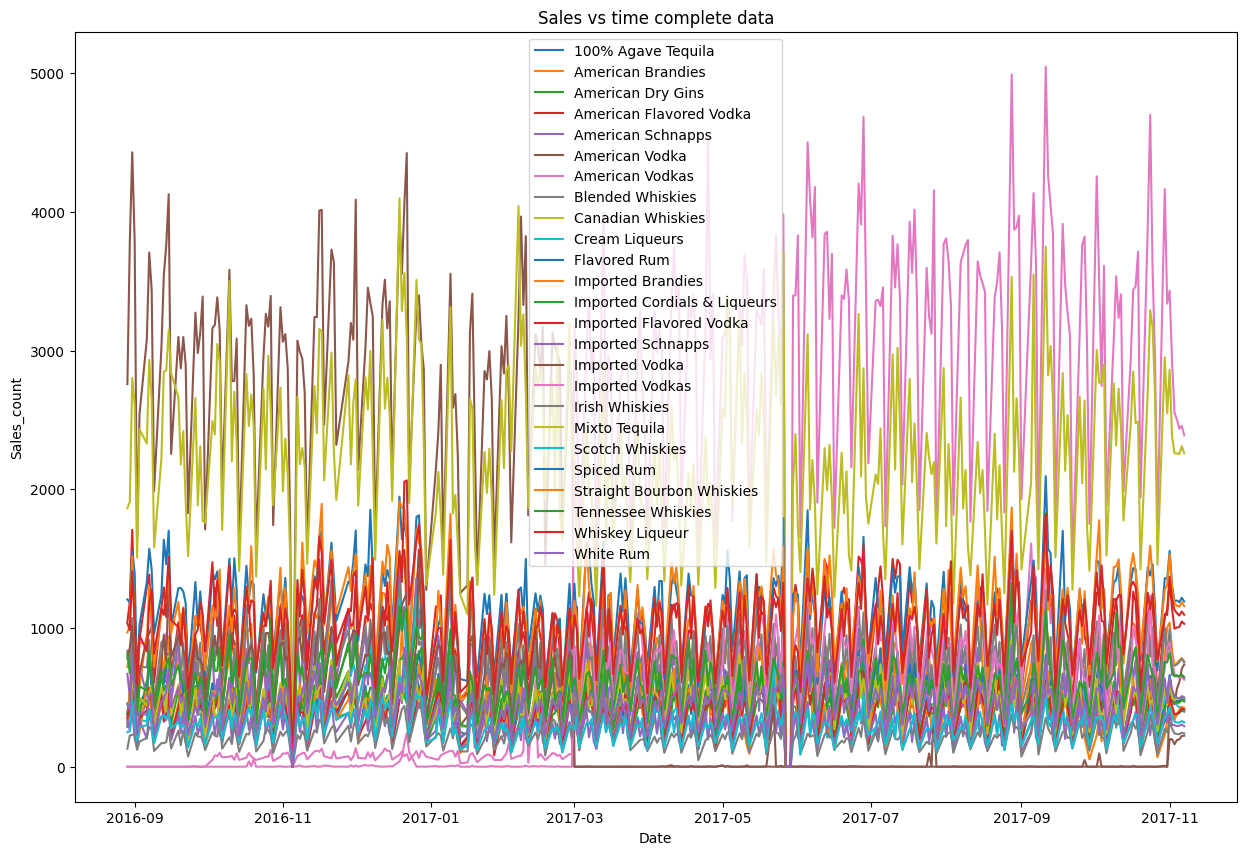

In [109]:
# Plotting the lines
plt.figure(figsize=(15, 10))
for col in combined_df.columns:
    plt.plot(combined_df.index, combined_df[col], label=col)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Sales_count')
plt.title('Sales vs time complete data')
plt.legend()
plt.show()

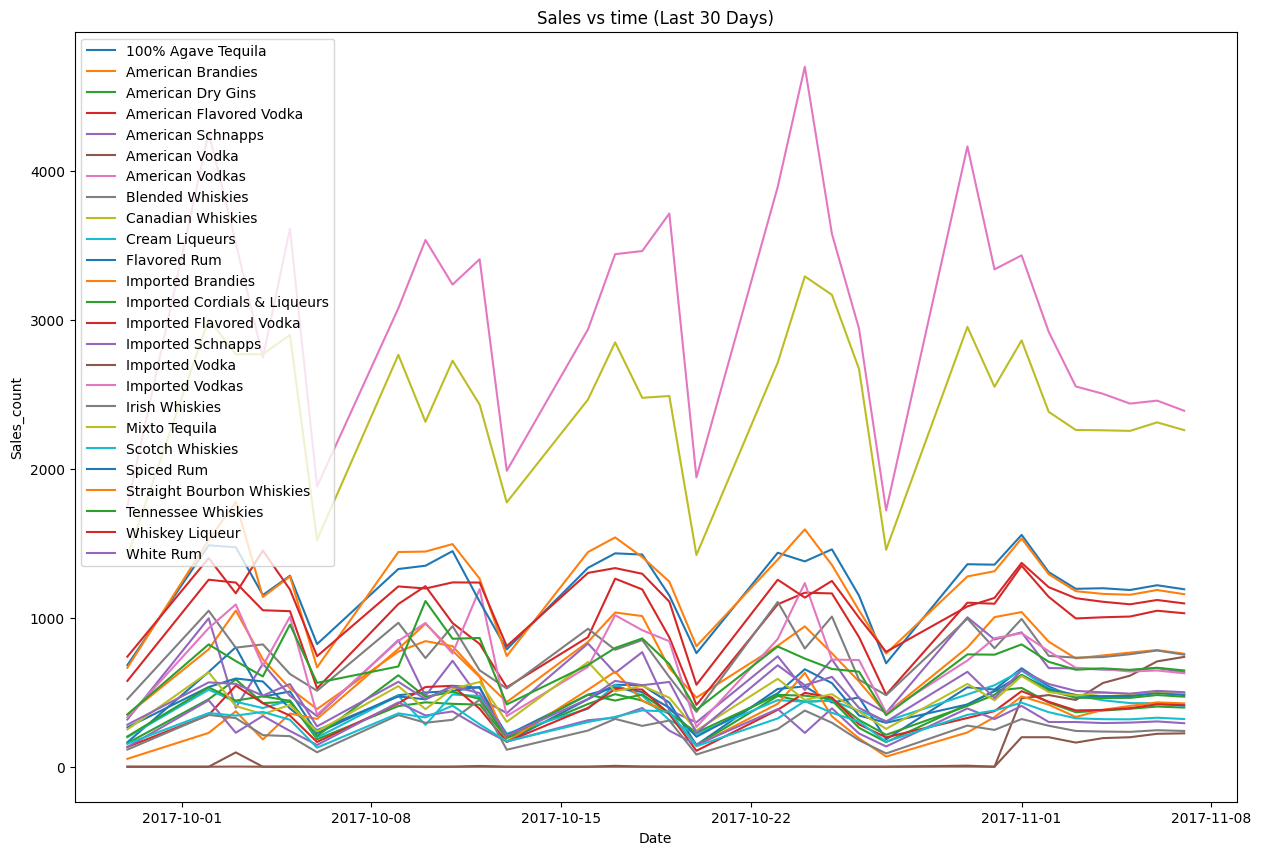

In [110]:
# Slice the DataFrame to include only the last 15 days
last_30_days_df = combined_df.iloc[-30:]

# Plotting the lines for the last 30 days
plt.figure(figsize=(15, 10))
for col in last_30_days_df.columns:
    plt.plot(last_30_days_df.index, last_30_days_df[col], label=col)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Sales_count')
plt.title('Sales vs time (Last 30 Days)')
plt.legend()
plt.show()
